In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal, matrix_normal, multivariate_t
import networkx as nx
import sys
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')
import DyGraph as dg
import CovReg as cr
import matplotlib.pyplot as plt
import tqdm
import scipy
from scipy.optimize import minimize
from sklearn import linear_model

from sklearn.metrics.pairwise import rbf_kernel
import pickle


In [2]:
def calc_shapley_value(B,X=None, Sigma = None):
    if Sigma is None:
        Sigma = np.cov(X.T)
    
    r = Sigma.shape[0]
    val_y = np.dot(B, Sigma).dot(B.T)

    d = val_y.shape[0]
    shapleys = np.zeros((int(d*(d+1)/2), r))
    index = np.arange(r)


    cnt=0
    for i in range(d):
        for j in range(i,d):
            for k in range(r):
                t1 = B[i,k]*B[j,k]*Sigma[k,k]
                t2 = 0.5*np.sum(B[i,index != k]*B[j,k]*Sigma[k,index != k])
                t3 = 0.5*np.sum(B[j,index != k]*B[i,k]*Sigma[k,index != k])
                shapleys[cnt,k] = t1+t2+t3
            cnt+=1

    return shapleys

In [3]:
def lasso_objective(param, X, Y,Psi_inv, d,r, alpha, Z1,Z2, kappa, const)->tuple:
    """"
    Objective and gradient to pass into the L-BFGS-B solver to solve the lasso problem.
    """

    C = np.reshape(param[:r*d]-param[r*d:],(d,r))
    
    obj =  np.trace(np.dot((Y- np.dot(X,C.T)).T,(Y- np.dot(X,C.T))).dot(Psi_inv)) + alpha*param.sum() + const*0.5*kappa*np.linalg.norm(C-Z1-Z2) ** 2
    t_0 = Y.T-np.dot(C,X.T)

    grad = (-0.5*np.dot(t_0,X) + const*kappa*(C-Z1-Z2)).flatten()[:d*r]
    return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None)



def dynamic_covreg(Y, X, n_t, alpha, kappa):

    n = X.shape[0]
    d = Y.shape[1]
    r = X.shape[1]

    rho = n_t
    alpha = alpha*n_t
    kappa = kappa*n_t

    Y_tilde = np.vstack((Y, np.zeros((n,d))))

    T = int(n/n_t)

    C = np.ones((T, d, r))

    U1 = np.ones((T, d, r))
    U2 = np.ones((T, d, r))

    Z1 = np.zeros((T, d, r))
    Z2 = np.zeros((T, d, r))

    

    Psi_pre_inv = np.identity(d)

    for t in range(T):
        C_t = C[t].copy()
        X_t = X[t*n_t:(t+1)*n_t].copy()
        Y_t = Y[t*n_t:(t+1)*n_t].copy()

        # E -step
        if t == 0:
            m = np.random.normal(size = n_t)
            v = np.ones(n_t)
        else:
            for i in range(n_t):
                v[i] = (1+np.dot(X_t[i].T, C_t.T).dot(Psi_pre_inv).dot(C_t).dot(X_t[i])) ** (-1)
                m[i] = v[i]*np.dot((Y_t[i]-0).T,Psi_pre_inv).dot(C_t).dot(X_t[i])

        X_tilde =  np.vstack((m[:,np.newaxis]*X,v[:,np.newaxis]*X))
        # M -step
        
        if (t == 0) or (t == T-1):
            const = 1.0
        else:
            const = 2.0
        out = minimize(lasso_objective, C_vec, args = (X_tilde, Y_tilde, np.identity(d),d,r, alpha, Z1,Z2, kappa, const), method='L-BFGS-B', jac=True, bounds = [(0,None)]*(2*r*d))
        C_vec = out.x
        C = np.reshape(out.x[:(r)*d] - out.x[(r)*d:], (d,r))



        








# Generate Data

In [4]:
ns = [100, 1000, 10000]
rs = [5, 10, 20, 50]
ds = [10]

def create_data(scale):
    rnd = np.random.RandomState(42)

    X = rnd.normal(loc = 0, scale = 1, size = (np.max(ns),np.max(rs)))

    B_dict_true = dict()
    A_dict_true = dict()
    Ys_dict_cov = dict()


    # Generate coef matrix
    for r in rs:
        for d in ds:
            B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
            B_true[np.abs(B_true)<0.7] = 0
            B_dict_true[str(r) + '_'+str(d)] = B_true
            A_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
            A_true[np.abs(A_true)<0.7] = 0
            A_dict_true[str(r) + '_'+str(d)] = A_true

    # Generate observations
    for r in rs:
        for d in ds:
            B_tmp = B_dict_true[str(r) + '_'+str(d)].copy()
            A_tmp = A_dict_true[str(r) + '_'+str(d)].copy()

            X_tmp = X[:,:r]
            gamma = rnd.normal(loc = 0, scale = 1, size = (np.max(ns)))
            #epsilon = rnd.normal(loc = 0, scale = 0.1, size = (np.max(ns),d))
            epsilon = rnd.normal(loc = 0, scale = scale, size = (np.max(ns), d))

            Y_cov = gamma[:, np.newaxis]*np.dot(X_tmp, B_tmp.T) + epsilon
            Ys_dict_cov[str(r) + '_'+str(d)] = Y_cov.copy()


        #Y_meancov = np.dot(X_tmp, A_tmp.T) + gamma[:, np.newaxis]*np.dot(X_tmp, B_tmp.T) + epsilon
        #Ys_dict_meancov[str(r) + '_'+str(d)] = Y_meancov.copy()

    return X, B_dict_true, A_dict_true, Ys_dict_cov

X, B_dict_true, A_dict_true, Ys_dict_cov = create_data(1)

In [16]:
n = 10000
r = 50


x = X[:n,:r]
y = Ys_dict_cov[str(r) + '_'+str(10)][:n]
B_true = B_dict_true[str(r) + '_10']
max_i, max_j = np.where(B_true == np.max(B_true))

tol = 1e-6

In [17]:
cov_direct = cr.CovReg( Y = y, alpha = 0, max_iter = 2000, tol = tol, method = 'secant') #secant_psi_identity
cov_direct.fit_hoff(X2 = x, verbose = True, C_init = 'cole', error = 'gaussian')
print(f'Error {np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_direct.B[max_i, max_j])*cov_direct.B - B_true)}')
B_tmp = cov_direct.B.copy()
B_tmp[np.abs(B_tmp)<1e-3] = 0.0
print(f'Nr params {np.sum(np.abs(B_tmp) >0)}')
marg_lik = cov_direct.marg_lik(X2 = x, error='gaussian')
lik = cov_direct.likelihood(X2 = x)
print(f'likelihood {lik}')
print(f'Marg. likelihood {-marg_lik}')
print(f'AIC likelihood {np.sum(np.abs(B_tmp) >1e-3) - lik}')
print(f'AIC Marg. likelihood {np.sum(np.abs(B_tmp) >1e-3) + marg_lik}')
#print(np.sum(np.abs(B_tmp) >0) + marg_lik )

Error 1.89E+0:   0%|          | 0/2000 [00:00<?, ?it/s]

Error 9.96E-7:  81%|████████  | 1618/2000 [00:31<00:07, 51.08it/s]


Error 0.29851395682726495
Nr params 472
likelihood -171680.7440900716
Marg. likelihood -233759.71268039048
AIC likelihood 172152.7440900716
AIC Marg. likelihood 234231.71268039048


In [10]:
np.sum(np.round(B_tmp,2) == 0)

99

In [12]:
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_direct.B[max_i, max_j])*cov_direct.B - B_true)

0.29851395682726495

In [13]:
cov_direct = cr.CovReg( Y = y, alpha = 10*1e-8, max_iter = 2000, tol = tol, method = 'secant') #secant_psi_identity
cov_direct.fit_hoff(X2 = x, verbose = True, C_init = 'cole', error = 'gaussian')
print(f'Error {np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_direct.B[max_i, max_j])*cov_direct.B - B_true)}')
B_tmp = cov_direct.B.copy()
B_tmp[np.abs(B_tmp)<1e-3] = 0.0
print(f'Nr params {np.sum(np.abs(B_tmp) >0)}')
marg_lik = cov_direct.marg_lik(X2 = x, error='gaussian')
lik = cov_direct.likelihood(X2 = x)
print(f'likelihood {lik}')
print(f'Marg. likelihood {-marg_lik}')
print(f'AIC likelihood {np.sum(np.abs(B_tmp) >1e-3) - lik}')
print(f'AIC Marg. likelihood {np.sum(np.abs(B_tmp) >1e-3) + marg_lik}')
#print(np.sum(np.abs(B_tmp) >0) + marg_lik )

  0%|          | 0/2000 [00:00<?, ?it/s]

Error 9.97E-7:  61%|██████    | 1211/2000 [00:55<00:35, 21.96it/s]


Error 2.5421028148429783
Nr params 451
likelihood -171835.16701721936
Marg. likelihood -233766.8171814004
AIC likelihood 172286.16701721936
AIC Marg. likelihood 234217.8171814004


# Analyze Gaussian case

In [5]:
n = 1000
r = 30
s = 1
w_1 = 100
with open(f'./experiment_paper/secant_n{n}_r{r}_s{s}.pkl', 'rb') as handle:
    shapley_secant = pickle.load(handle)

Text(0, 0.5, 'Error')

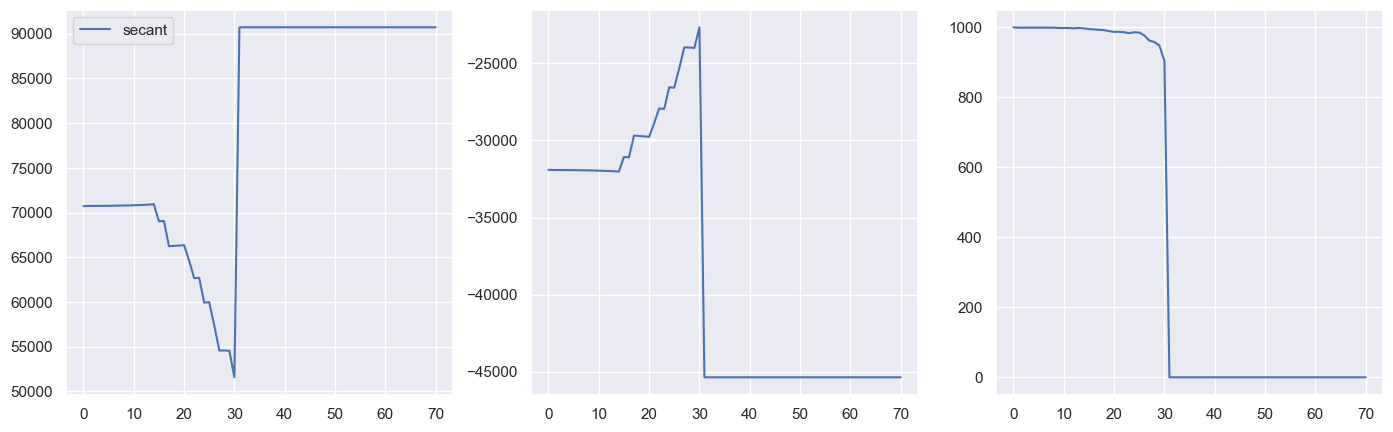

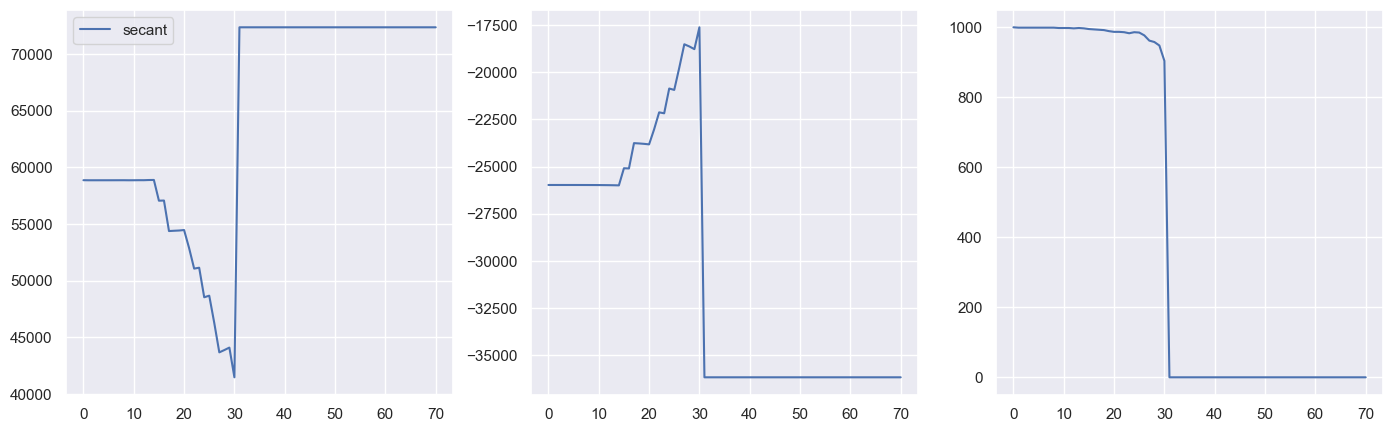

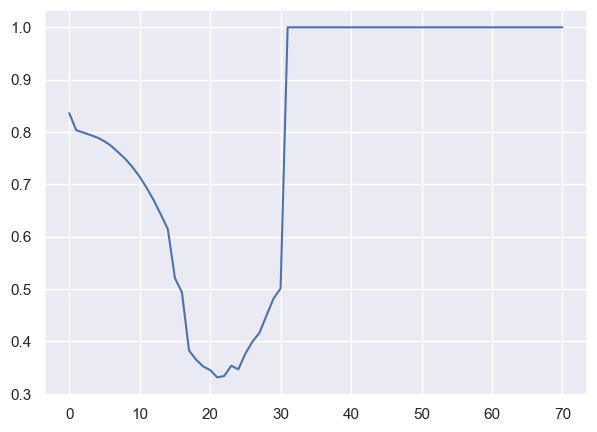

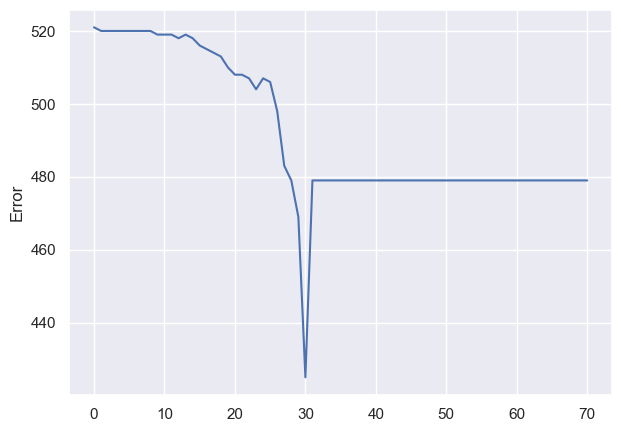

In [6]:
n = 1000
r = 100
s = 1
w_1 = 100
with open(f'./experiment_paper/secant_n{n}_r{r}_s{s}.pkl', 'rb') as handle:
    shapley_secant = pickle.load(handle)


fig, ax = plt.subplots(1,3, figsize = (17,5))
ax[0].plot((np.log(n)*shapley_secant['nr_params']+2*shapley_secant['marg_liks'])[:w_1], label = 'secant' )
ax[0].legend()

ax[1].plot(-shapley_secant['marg_liks'][:w_1], label = 'secant' )

ax[2].plot(shapley_secant['nr_params'][:w_1], label = 'secant' )

    
fig, ax = plt.subplots(1,3, figsize = (17,5))

ax[0].plot((np.log(n)*shapley_secant['nr_params']-2*shapley_secant['liks'])[:w_1], label = 'secant' )
ax[0].legend()

ax[1].plot(shapley_secant['liks'][:w_1], label = 'secant' )

ax[2].plot(shapley_secant['nr_params'][:w_1], label = 'secant' )



B_true = shapley_secant['B_true'].copy()
fig, ax = plt.subplots(1,1, figsize = (7,5))
ax.plot((shapley_secant['B_errors']/np.linalg.norm(B_true))[:w_1], label = 'secant' )

def one_zero_error(obj):

    B_true = obj['B_true'].copy()
    max_i, max_j = np.where(B_true == np.max(B_true))
    sign_error = []
    for i in range(obj['B_est'].shape[0]):
        B_tmp = obj['B_est'][i].copy()
        B_tmp[np.abs(B_tmp)<1e-3] = 0
            #np.sign(B_true[max_i, max_j])*np.sign(B_tmp[max_i, max_j])*
        sign_error.append(np.sum(np.sign(np.abs(B_tmp)) != np.sign(np.abs(B_true)) ))


    return np.array(sign_error)




fig, ax = plt.subplots(1,1, figsize = (7,5))
ax.plot(one_zero_error(shapley_secant), label = 'secant' )
ax.set_ylabel("Zero-one error")

ax.set_ylabel("Error")

In [5]:
B_est = shapley_secant['B_est'][25].copy()
B_est[np.abs(B_est)<1e-3] = 0

print(np.round(B_est, 2))
print("")
print(np.round(shapley_secant['B_true'], 2))
print("")
print(np.sign(B_est) != np.sign(shapley_secant['B_true']))
print(np.sum(np.sign(B_est) != np.sign(shapley_secant['B_true'])))

[[ 0.77 -0.83  0.03  0.02 -0.06]
 [-0.04  0.   -1.25  0.99  0.85]
 [ 0.    0.73  0.03 -0.71  0.  ]
 [-0.81  0.   -0.49 -1.2  -2.69]
 [ 0.    0.    0.99 -1.25  0.76]
 [-0.02  0.    0.03  0.03 -1.48]
 [ 0.52  0.59  0.69  0.    0.  ]
 [-1.07  0.   -0.02  0.    0.  ]
 [ 0.   -0.03 -0.88  0.01  1.13]
 [-0.83  0.79  0.5  -1.22  0.  ]]

[[ 1.03 -1.16  0.    0.    0.  ]
 [ 0.    0.   -1.68  1.38  1.13]
 [ 0.    0.93  0.   -0.98  0.  ]
 [-1.17  0.   -0.7  -1.6  -3.63]
 [ 0.    0.    1.34 -1.74  1.01]
 [ 0.    0.    0.    0.   -2.03]
 [ 0.72  0.83  0.96  0.    0.  ]
 [-1.47  0.    0.    0.    0.  ]
 [ 0.    0.   -1.18  0.    1.47]
 [-1.1   1.    0.71 -1.71  0.  ]]

[[False False  True  True  True]
 [ True False False False False]
 [False False  True False False]
 [False False False False False]
 [False False False False False]
 [ True False  True  True False]
 [False False False False False]
 [False False  True False False]
 [False  True False  True False]
 [False False False False  True]]
12


In [8]:
shapley_secant.keys()

dict_keys(['alphas', 'B_true', 'method', 'B_errors', 'marg_liks', 'nr_params', 'sign_error', 'liks', 'B_est', 'Psi_est'])

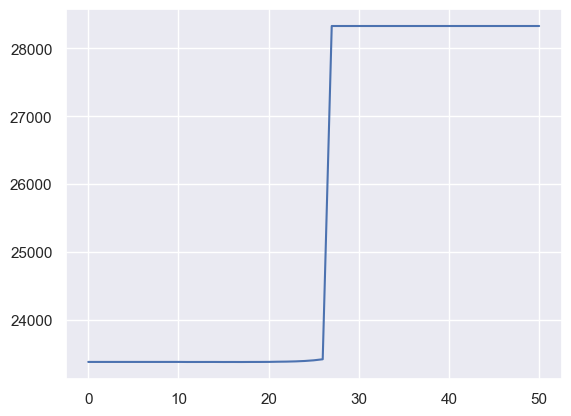

In [8]:
plt.plot(shapley_secant['nr_params']+shapley_secant['marg_liks'])

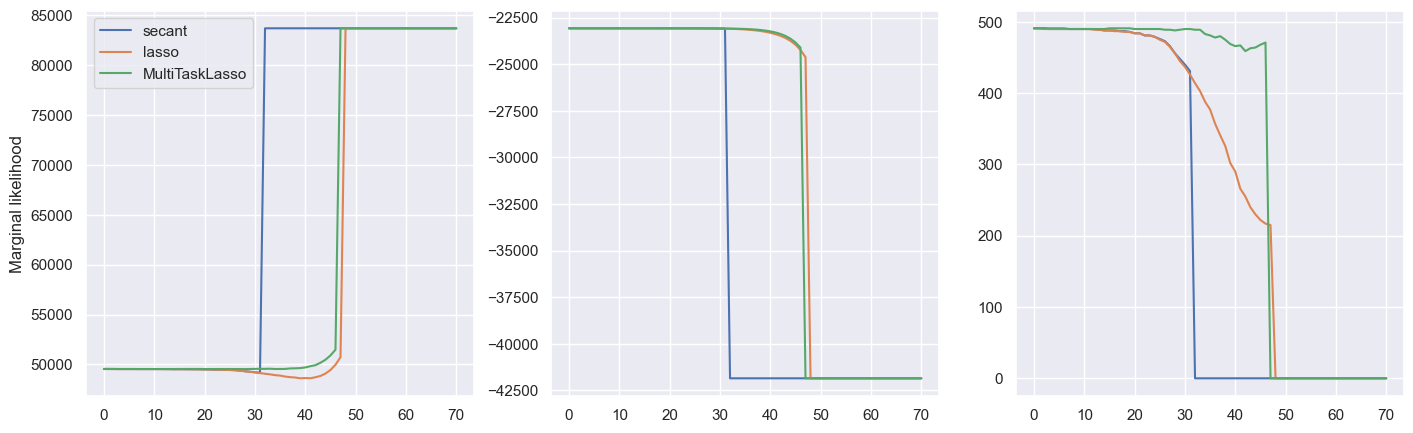

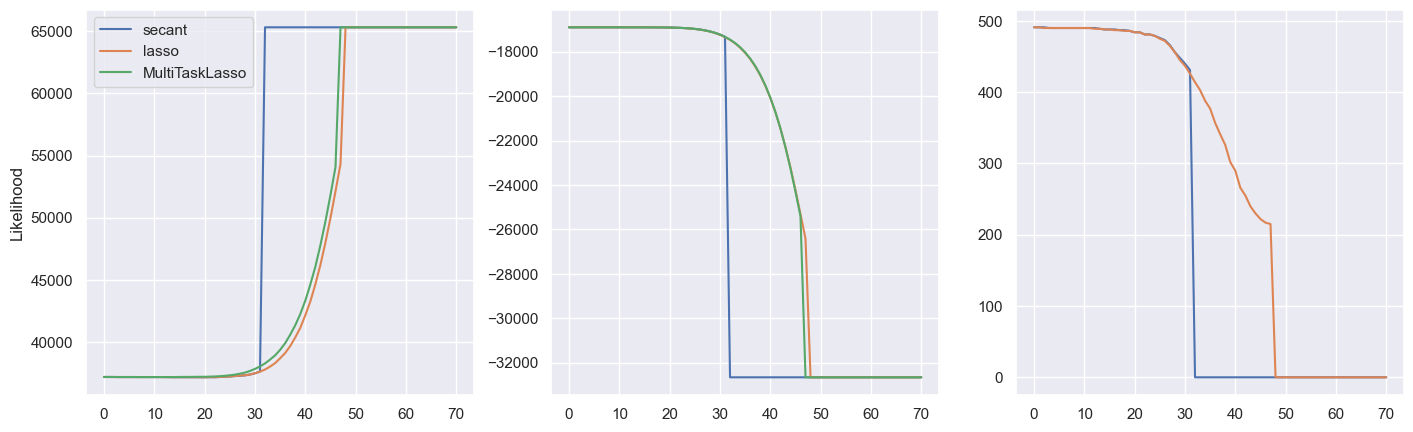

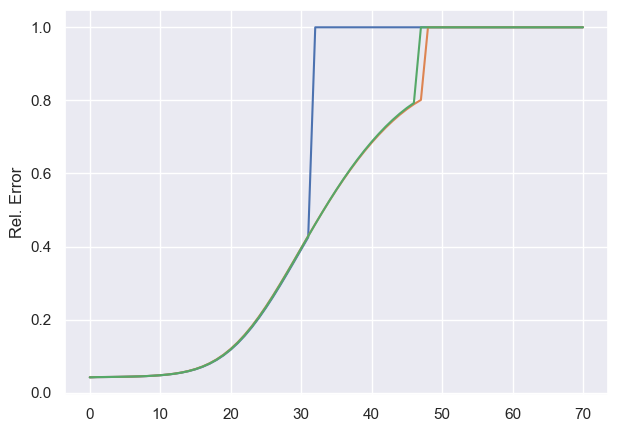

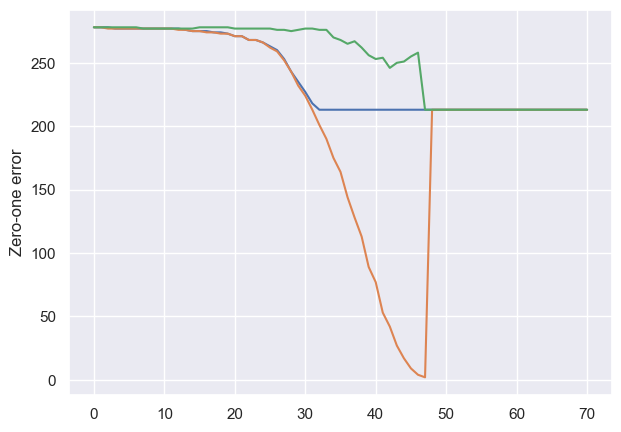

In [14]:
rs = np.array([5, 10, 20, 30, 40, 50])

shapley_secant = dict()
for i in rs:
    with open(f'./experiment_paper/secant_n{n}_r{i}_s{s}.pkl', 'rb') as handle:
        shapley_secant[i] = pickle.load(handle)

shapley_secant_nopsi = dict()
for i in rs:
    with open(f'./experiment_paper/secant_psi_identity_n{n}_r{i}_s{s}.pkl', 'rb') as handle:
        shapley_secant_nopsi[i] = pickle.load(handle)


shapley_mtl = dict()
for i in rs:
    with open(f'./experiment_paper/MultiTaskLasso_n{n}_r{i}_s{s}.pkl', 'rb') as handle:
        shapley_mtl[i] = pickle.load(handle)

def read_and_analyze(r, n = 1000, s= 1, w_1 = 50, lim1 = None, lim2 = None):



    fig, ax = plt.subplots(1,3, figsize = (17,5))
    ax[0].plot((np.log(n)*shapley_secant[r]['nr_params']+2*shapley_secant[r]['marg_liks'])[:w_1], label = 'secant' )
    ax[0].plot((np.log(n)*shapley_secant_nopsi[r]['nr_params']+2*shapley_secant_nopsi[r]['marg_liks'])[:w_1], label = 'lasso' )
    ax[0].plot((np.log(n)*shapley_mtl[r]['nr_params']+2*shapley_mtl[r]['marg_liks'])[:w_1], label = 'MultiTaskLasso' )
    ax[0].set_ylabel("Marginal likelihood")
    ax[0].legend()
    if lim1 is not None:
        ax[0].set_ylim(lim1)

    ax[1].plot(-shapley_secant[r]['marg_liks'][:w_1], label = 'secant' )
    ax[1].plot(-shapley_secant_nopsi[r]['marg_liks'][:w_1], label = 'lasso' )
    ax[1].plot(-shapley_mtl[r]['marg_liks'][:w_1], label = 'MultiTaskLasso' )

    ax[2].plot(shapley_secant[r]['nr_params'][:w_1], label = 'secant' )
    ax[2].plot(shapley_secant_nopsi[r]['nr_params'][:w_1], label = 'lasso' )
    ax[2].plot(shapley_mtl[r]['nr_params'][:w_1], label = 'MultiTaskLasso' )

    
    fig, ax = plt.subplots(1,3, figsize = (17,5))
    ax[0].plot((np.log(n)*shapley_secant[r]['nr_params']-2*shapley_secant[r]['liks'])[:w_1], label = 'secant' )
    ax[0].plot((np.log(n)*shapley_secant_nopsi[r]['nr_params']-2*shapley_secant_nopsi[r]['liks'])[:w_1], label = 'lasso' )
    ax[0].plot((np.log(n)*shapley_mtl[r]['nr_params']-2*shapley_mtl[r]['liks'])[:w_1], label = 'MultiTaskLasso' )
    ax[0].set_ylabel("Likelihood")
    ax[0].legend()
    if lim2 is not None:
        ax[0].set_ylim(lim2)

    ax[1].plot(shapley_secant[r]['liks'][:w_1], label = 'secant' )
    ax[1].plot(shapley_secant_nopsi[r]['liks'][:w_1], label = 'lasso' )
    ax[1].plot(shapley_mtl[r]['liks'][:w_1], label = 'MultiTaskLasso' )

    ax[2].plot(shapley_secant[r]['nr_params'][:w_1], label = 'secant' )
    ax[2].plot(shapley_secant_nopsi[r]['nr_params'][:w_1], label = 'lasso' )


    B_true = shapley_secant[r]['B_true'].copy()
    fig, ax = plt.subplots(1,1, figsize = (7,5))
    ax.plot((shapley_secant[r]['B_errors']/np.linalg.norm(B_true))[:w_1], label = 'secant' )
    ax.plot((shapley_secant_nopsi[r]['B_errors']/np.linalg.norm(B_true))[:w_1], label = 'lasso' )
    ax.plot((shapley_mtl[r]['B_errors']/np.linalg.norm(B_true))[:w_1], label = 'MultiTaskLasso' )

    ax.set_ylabel("Rel. Error")

    def one_zero_error(obj):

        B_true = obj['B_true'].copy()
        max_i, max_j = np.where(B_true == np.max(B_true))
        sign_error = []
        for i in range(obj['B_est'].shape[0]):
            B_tmp = obj['B_est'][i].copy()
            B_tmp[np.abs(B_tmp)<1e-3] = 0
                #np.sign(B_true[max_i, max_j])*np.sign(B_tmp[max_i, max_j])*
            sign_error.append(np.sum(np.sign(np.abs(B_tmp)) != np.sign(np.abs(B_true)) ))


        return np.array(sign_error)




    fig, ax = plt.subplots(1,1, figsize = (7,5))
    ax.plot(one_zero_error(shapley_secant[r]), label = 'secant' )
    ax.plot(one_zero_error(shapley_secant_nopsi[r]), label = 'lasso' )
    ax.plot(one_zero_error(shapley_mtl[r]), label = 'MultiTaskLasso' )
    ax.set_ylabel("Zero-one error")


read_and_analyze(50, n = 1000, w_1=80, s=1, lim1= None, lim2 = None)

# Analyze Cov regression experiment

In [ ]:
#with open(f'C:/Users/ragna/Documents/Code/DyGraph/CovRegressionPaper/data_sim/shapley_less.pkl', 'rb') as handle:
with open(f'./data_sim/shapley_secant_cole.pkl', 'rb') as handle:
    shapley_secant = pickle.load(handle)
print(shapley_secant.keys())

with open(f'./data_sim/shapley_secant_psi_identity_cole.pkl', 'rb') as handle:
    shapley_secant_psi_identity = pickle.load(handle)
shapley_secant_psi_identity.keys()

with open(f'./data_sim/shapley_Lasso_cole.pkl', 'rb') as handle:
    shapley_lasso = pickle.load(handle)
shapley_lasso.keys()

with open(f'./data_sim/shapley_MultiTaskLasso_cole.pkl', 'rb') as handle:
    shapley_mtlasso = pickle.load(handle)
shapley_mtlasso.keys()

alphas = np.concatenate(([0], np.logspace(-5,-1, 100)))

dict_keys(['marg_liks_dict', 'liks_dict', 'l2_dict', 'psi_est', 'nr_param_dict', 'B_est', 'B_true', 'Ys_dict_cov', 'X'])


How close to B

NameError: name 'alphas' is not defined

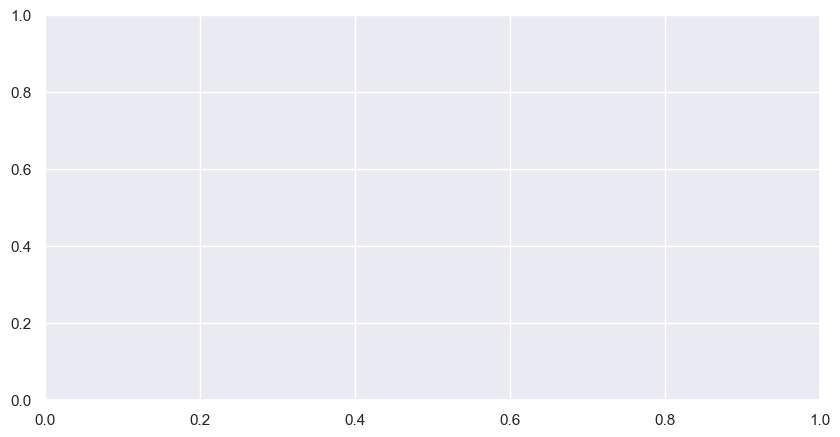

In [65]:
def compare_closeness(obj, r, n):

    k = len(obj['B_est'][r][n])
    
    return [np.sum(np.abs(np.abs(obj['B_est'][r][n][i]) - np.abs(obj['B_true'][str(r) + "_10"]))) for i in range(k)]


def sign_close(obj, r, n):

    k = len(obj['B_est'][r][n])

    ests = []
    for i in range(len(obj['B_est'][r][n])):
        est = obj['B_est'][r][n][i].copy()
        est[np.abs(est)<1e-3] = 0
        ests.append(est)
    true = obj['B_true'][str(r) + "_10"]
    true[np.abs(true) < 1e-3] = 0

    return [np.sum(np.sign(np.abs(ests[i])) != np.sign(np.abs(true)) ) for i in range(k)]


def plot_closeness(r, n, nr_alpha):

    fig, ax = plt.subplots(1,1, figsize = (10,5))
    ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), compare_closeness(shapley_secant,r,n)[:nr_alpha], label = 'secant')
    ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), compare_closeness(shapley_secant_psi_identity,r,n)[:nr_alpha], label = 'secant no psi')
    # ax.plot(np.concatenate(([-9], np.log10(alphas[1:nr_alpha]))), compare_closeness(shapley_lasso,r,n)[:nr_alpha], label = 'lasso')
    ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), compare_closeness(shapley_mtlasso,r,n)[:nr_alpha], label = 'mtl')
    ax.legend()
    #ax.set_ylim((0,20))


def plot_sign(r, n, nr_alpha):



    fig, ax = plt.subplots(1,1, figsize = (10,5))
    ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), sign_close(shapley_secant,r,n)[:nr_alpha], label = 'secant')
    ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), sign_close(shapley_secant_psi_identity,r,n)[:nr_alpha], label = 'secant no psi')
    # ax.plot(np.concatenate(([-9], np.log10(alphas[1:nr_alpha]))), compare_closeness(shapley_lasso,r,n)[:nr_alpha], label = 'lasso')
    ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), sign_close(shapley_mtlasso,r,n)[:nr_alpha], label = 'mtl')
    ax.legend()
    #ax.set_ylim((0,20))




plot_closeness(100, 100, 80)
plot_sign(100, 100, 80)

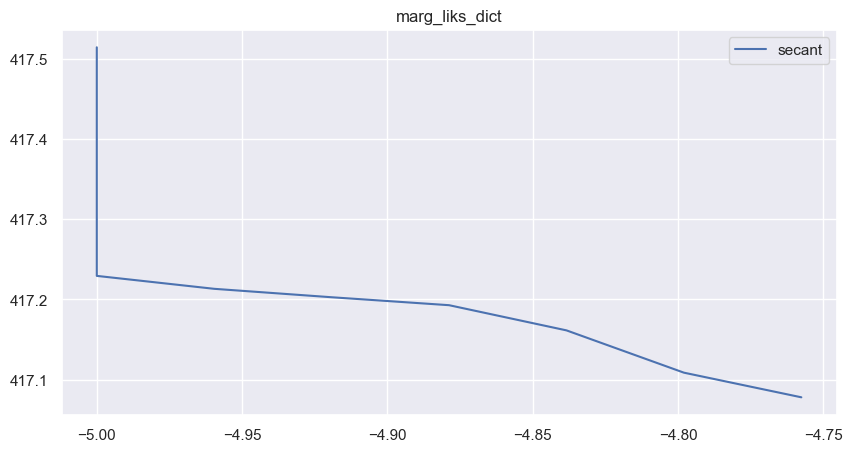

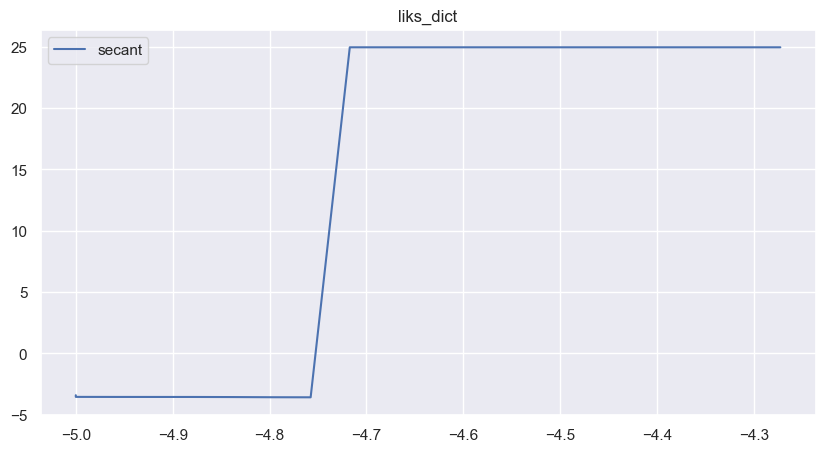

In [17]:

def plot_lik(r, n, nr_alpha, liktype):



    fig, ax = plt.subplots(1,1, figsize = (10,5))
    ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), -np.array(shapley_secant[liktype][r][n][:nr_alpha]), label = 'secant')
    #ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), -np.array(shapley_secant_psi_identity[liktype][r][n][:nr_alpha]), label = 'secant no psi')
    # ax.plot(np.concatenate(([-20], np.log(alphas[1:nr_alpha]))), shapley_lasso[liktype][30][1000][:nr_alpha], label = 'lasso')
    #ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), -np.array(shapley_mtlasso[liktype][r][n][:nr_alpha]), label = 'mtl')
    ax.legend()
    ax.set_title(liktype)

plot_lik(30, 1000, 8, liktype = 'marg_liks_dict')
plot_lik(30, 1000, 20, liktype = 'liks_dict')

In [19]:
np.log10(alphas)[50]

C:\Users\User\AppData\Local\Temp\ipykernel_5072\826597654.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(alphas)[50]


-2.186440677966101

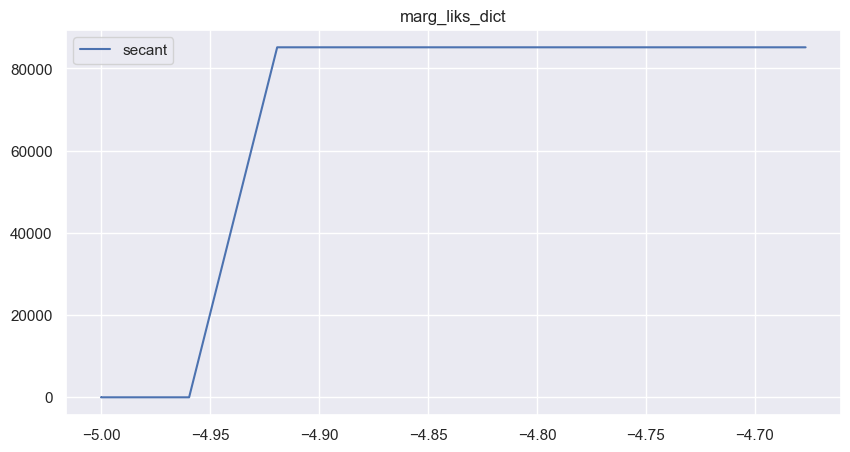

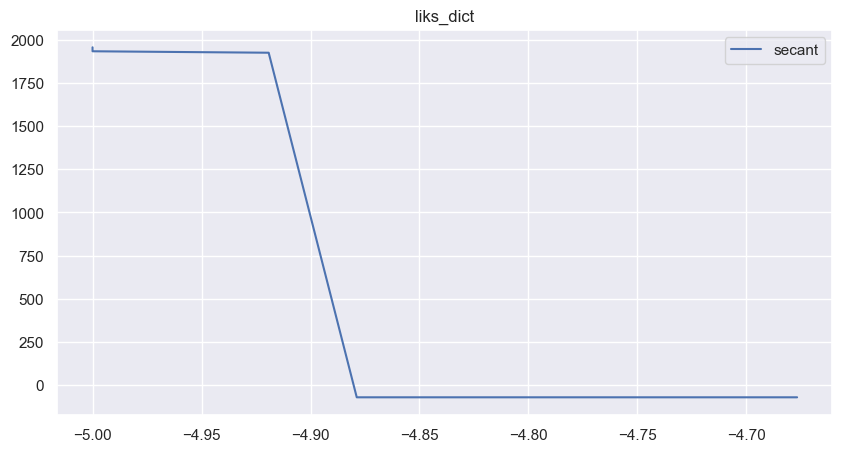

In [22]:
def plot_aic(r, n, nr_alpha, liktype, ylim = None):



    fig, ax = plt.subplots(1,1, figsize = (10,5))
    ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), 2*np.array(shapley_secant['nr_param_dict'][r][n][:nr_alpha])+2*np.array(shapley_secant[liktype][r][n][:nr_alpha]), label = 'secant')
    #ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), 2*np.array(shapley_secant_psi_identity['nr_param_dict'][r][n][:nr_alpha])+2*np.array(shapley_secant_psi_identity[liktype][r][n][:nr_alpha]), label = 'secant no psi')
    # ax.plot(np.concatenate(([-20], np.log(alphas[1:nr_alpha]))), shapley_lasso[liktype][30][1000][:nr_alpha], label = 'lasso')
    #ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), 2*np.array(shapley_mtlasso['nr_param_dict'][r][n][:nr_alpha])+2*np.array(shapley_mtlasso[liktype][r][n][:nr_alpha]), label = 'mtl')
    ax.legend()
    ax.set_title(liktype)
    if ylim is not None:
        ax.set_ylim(ylim)


plot_aic(50, 1000, 10, liktype = 'marg_liks_dict')
plot_aic(100, 1000, 10, liktype = 'liks_dict')
#plot_aic(5, 1000, 35, liktype = 'liks_dict')

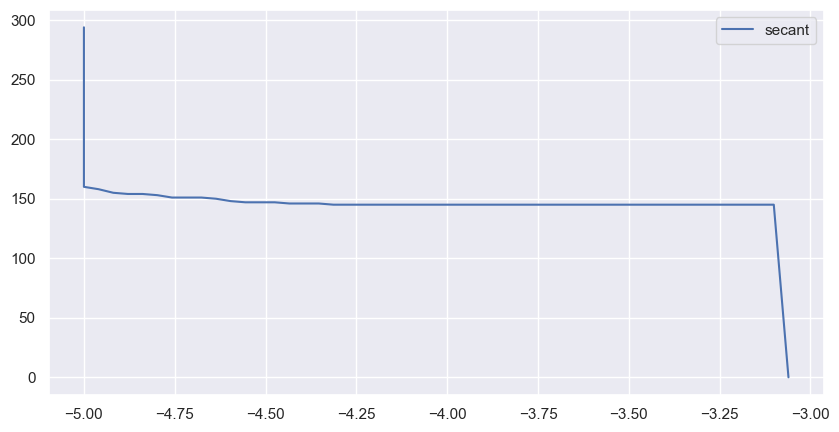

In [43]:
def plot_nr_param(r, n, nr_alpha):



    fig, ax = plt.subplots(1,1, figsize = (10,5))
    ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), np.array(shapley_lasso['nr_param_dict'][r][n][:nr_alpha]), label = 'secant')
    #ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), np.array(shapley_secant_psi_identity['nr_param_dict'][r][n][:nr_alpha]), label = 'secant no psi')
    # ax.plot(np.concatenate(([-20], np.log(alphas[1:nr_alpha]))), shapley_lasso[liktype][30][1000][:nr_alpha], label = 'lasso')
    #ax.plot(np.concatenate(([np.log10(alphas[1])], np.log10(alphas[1:nr_alpha]))), np.array(shapley_mtlasso['nr_param_dict'][r][n][:nr_alpha]), label = 'mtl')
    ax.legend()

plot_nr_param(30, 1000, 50)

In [ ]:
cov_secant_id = cr.CovReg( Y = y, alpha = 0, max_iter = 100, tol = 1e-6, method= 'Lasso')
cov_secant_id.fit_hoff_b_only(X2 = x, verbose = False)

np.sum(np.abs(np.abs(cov_secant_id.B) - np.abs(B_dict_true['100_10'])))


773.1849257384572

In [4]:
# alphas = shap_data['alphas']
# ns = shap_data['ns']
# rs = shap_data['rs']
# ds = shap_data['ds']
# value_function_cov_dict = shap_data['value_function_cov_dict']
# value_function_meancov_dict = shap_data['value_function_meancov_dict']
# B_dict_cov = shap_data['B_dict_cov']
# B_dict_cov_psi = shap_data['B_dict_cov_psi']
# B_dict_meancov = shap_data['B_dict_meancov']
# B_dict_true = shap_data['B_dict_true']
# val_y_true = shap_data['val_y_true']
# Psi_dict_cov = shap_data['Psi_dict_cov']
# Psi_dict_meancov = shap_data['Psi_dict_meancov']
# Xs_dict = shap_data['Xs_dict']
# Y_cov = shap_data['Ys_dict_cov']
# Y_meancov = shap_data['Ys_dict_meancov']

# lik_cov_dict  = shap_data['lik_cov_dict']
# lik_meancov_dict  = shap_data['lik_meancov_dict']
# lik_cov_psi_dict  = shap_data['lik_cov_psi_dict']
# lik_meancov_psi_dict  = shap_data['lik_meancov_psi_dict']

# nr_param_cov_dict  = shap_data['nr_param_cov_dict']
# nr_param_meancov_dict  = shap_data['nr_param_meancov_dict']
# nr_param_cov_psi_dict  = shap_data['nr_param_cov_psi_dict']
# nr_param_meancov_psi_dict  = shap_data['nr_param_meancov_psi_dict']


# colors = ['blue', 'orange', 'red', 'green', 'purple']  # colors for number of observation distiction

(7000.0, 9000.0)

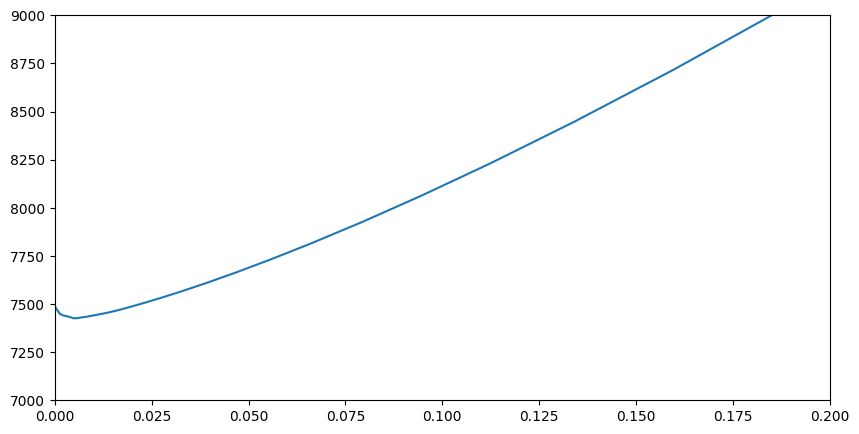

In [18]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
alphas = np.concatenate(([0], np.logspace(-4,0.5, 60)))
# ax.plot(alphas,shap_data['liks_dict'][50][1000]+shap_data['nr_param_dict'][50][1000])
# ax.set_xlim((0,0.2))
# ax.set_ylim((22500, 25000))


# ax.plot(alphas,shap_data0['liks_dict'][50][500]+shap_data['nr_param_dict'][50][500])
# ax.set_xlim((0,0.2))
#ax.set_ylim((3000, 10000))

ax.plot(alphas,shap_data['liks_dict'][20][1000]+shap_data['nr_param_dict'][20][1000])
ax.set_xlim((0,0.2))
ax.set_ylim((7000, 9000))

In [34]:
shap_data['B_est'].keys()

dict_keys([5, 10, 20, 50, 100])

In [47]:
shap_data['B_est'][20][100][4]

array([[ 9.28194226e+00,  7.06254770e+00,  6.82180983e+00,
         7.55105826e+00,  6.57508175e+00, -1.22707629e+00,
        -1.58874135e-01,  1.01057959e+01, -3.96736717e+00,
        -1.34699390e+00, -5.84284133e-01, -3.06941631e+00,
         3.53676296e+00, -1.16735641e+01,  1.18129279e+01,
        -4.49840076e+00,  7.85707751e+00,  8.63028022e-01,
         8.47014583e-01,  7.86289851e+00],
       [ 2.61724409e+00, -5.76314368e+00, -2.90390795e+00,
        -6.26617267e+00, -1.04005067e+01, -2.14031136e+00,
         5.46968940e-01,  1.58224980e+00, -2.90044557e+00,
        -1.28929934e+00,  1.71637458e+01, -8.73288739e+00,
         5.44538016e+00, -4.22811324e+00,  1.08010242e+01,
         8.61591016e+00, -1.49142974e+01,  2.56914157e+00,
        -1.35711295e-01, -6.00245435e+00],
       [-6.19146115e+00,  1.44674929e+01,  7.32970678e+00,
        -1.27976716e+00, -5.79656629e+00, -5.59112330e-01,
        -6.37560165e+00,  3.12471105e-02,  2.82664495e+00,
        -3.44319502e+00,  4.1

In [43]:
[np.sum(np.linalg.norm(np.abs(shap_data['B_est'][20][100][i]) - np.abs(shap_data['B_true']['20_10']))) for i in range(len(alphas))]

[329.6379425097295,
 124.9745438644104,
 114.01894501617319,
 102.31392081825452,
 91.78536142463727,
 81.53280656911151,
 73.56684611031498,
 65.51134418409455,
 58.42332736013571,
 51.94683358214404,
 46.0325690331559,
 40.841129064025736,
 36.14548834638926,
 31.923781143857198,
 28.118532816388004,
 24.756555619609937,
 21.752066520828254,
 19.13568502450293,
 16.872536252534985,
 14.960712429118916,
 13.395407828969397,
 12.142583673365833,
 11.197624329931525,
 10.537733980438958,
 10.126207285141893,
 9.920746662271146,
 9.87819271790574,
 9.957444319948936,
 10.119664231871525,
 10.333561830126786,
 10.576716475606068,
 10.834517357441607,
 11.061914447571668,
 11.225087458633638,
 11.40562762166024,
 11.61274642587598,
 11.747581078769416,
 11.906127912355103,
 12.070193750781838,
 12.2420730937108,
 12.404733098845734,
 12.554000527794678,
 12.659551073808228,
 12.786822552581373,
 12.964938472312125,
 12.962270365767012,
 13.16727291322836,
 13.261347592767661,
 13.361506626

(0.0, 0.05)

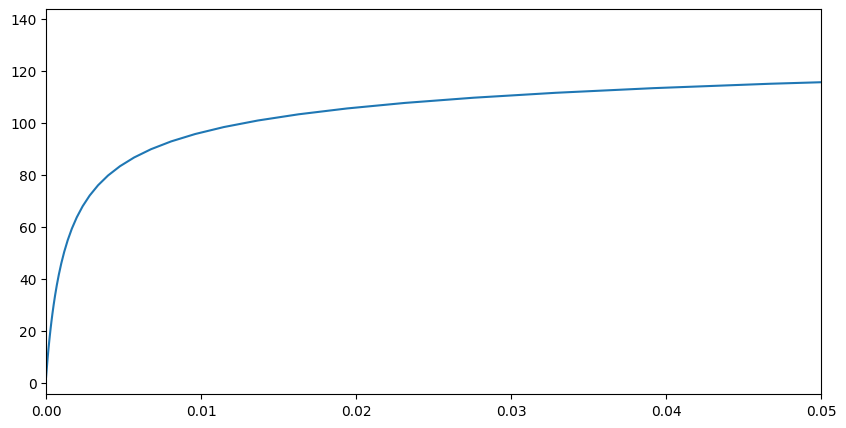

In [37]:

fig, ax = plt.subplots(1,1, figsize = (10,5))
alphas = np.concatenate(([0], np.logspace(-4,0.5, 60)))



ax.plot(alphas,[np.sum(np.abs(np.abs(shap_data['B_est'][20][1000][i]) - np.abs(shap_data['B_true']['20_10']))) for i in range(len(alphas))])
ax.set_xlim((0,0.05))
#ax.set_ylim((7000, 9000))

In [8]:
r = 100
d = 10

liks_dict_100 = dict()
nr_param_dict_100 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False, psi = np.identity(d))
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_100[n] = np.array(liks)
    nr_param_dict_100[n] = np.array(nr_param)

NameError: name 'ns' is not defined

In [54]:
r = 50
d = 10

liks_dict_50 = dict()
nr_param_dict_50 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False)
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_50[n] = np.array(liks)
    nr_param_dict_50[n] = np.array(nr_param)

C:\Users/ragna/Documents/Code/DyGraph/src\CovReg\covreg.py:171: RuntimeWarning: invalid value encountered in scalar divide
  tol_i = np.linalg.norm(C-C_pre)/np.linalg.norm(C_pre)


In [ ]:
r = 20
d = 10

liks_dict_20 = dict()
nr_param_dict_20 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False, psi = np.identity(d))
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_20[n] = np.array(liks)
    nr_param_dict_20[n] = np.array(nr_param)

In [58]:
r = 10
d = 10

liks_dict_10 = dict()
nr_param_dict_10 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False)
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_10[n] = np.array(liks)
    nr_param_dict_10[n] = np.array(nr_param)

In [59]:
r = 5
d = 10

liks_dict_5 = dict()
nr_param_dict_5 = dict()
alphas = np.concatenate(([0], np.logspace(-2,0, 20)))
for n in ns:
    liks = []
    nr_param = []
    for a in range(len(alphas)):
        #psi = Psi_dict_cov[str(r) + '_'+str(d)][k][a]
        #B_tmp = B_dict_cov[str(r) + '_'+str(d)][k][a]
        #nr_param.append(np.sum(np.abs(B_tmp)>1e-3))

        x = Xs_dict[str(r)][:n]
        y = Ys_dict_cov[str(r) + '_'+str(d)][:n]

        cov = cr.CovReg( Y = y, alpha = alphas[a], max_iter = 100, tol = 1e-6)
        cov.fit_hoff_b_only(X2 = x, verbose = False)
        l, npara = cov.marg_lik(X2 = x)
        liks.append(l)
        nr_param.append(npara)

    liks_dict_5[n] = np.array(liks)
    nr_param_dict_5[n] = np.array(nr_param)

In [9]:
def plot_ic(nr_param, liks, ns):

    fig, ax = plt.subplots(1,3, figsize = (15,5))
    for n in ns:
        ax[0].plot(alphas,(nr_param[n] + liks[n])/np.max(nr_param[n] + liks[n]), label = n)
        ax[1].plot(alphas,-liks[n]/np.max(np.abs(liks[n])), label = n)
        ax[2].plot(alphas,nr_param[n], label = n)


plot_ic(nr_param_dict_100, liks_dict_100, ns)
#plot_ic(nr_param_dict_50, liks_dict_50, ns)
plot_ic(nr_param_dict_20, liks_dict_20, ns)
#plot_ic(nr_param_dict_10, liks_dict_10, ns)
#plot_ic(nr_param_dict_5, liks_dict_5, ns)


NameError: name 'ns' is not defined

In [27]:
X_tmp = Xs_dict[str(20)]
Y_tmp = Y_meancov['20_10']

cov = cr.CovReg( Y = Y_tmp, alpha = alphas[10], max_iter = 1000, tol = 1e-3)
cov.fit_hoff_b_only(X2 = X_tmp, verbose = False)

In [8]:
print(cov.B[0,:])
print(B_dict_cov['20_10'][2][10][0,:])
print(B_dict_true['20_10'][0,:])

[ 0.03817281 -0.96973342  0.78159217 -1.38798284  0.38062207  1.98705786
  0.83122649 -0.27393128  0.00511562  0.1064922   0.02398483  0.00994861
 -0.07570683 -0.04043651 -0.04051687 -0.02483846 -0.04341337 -0.06822883
  0.00980958 -0.69398925]
[ 0.03014479 -0.86236763  0.72111814 -1.23308112  0.22761168  1.20140144
  0.49716401 -0.30090752  0.023616    0.          0.02758779  0.02113169
  0.00817007 -0.01205592 -0.01394336 -0.04916284 -0.00566186 -0.0231371
  0.         -0.56091589]
[-0.          1.10675862 -0.90772967  1.57616423 -0.28517645 -1.55622133
 -0.68958181  0.35653704  0.         -0.          0.         -0.
  0.          0.          0.          0.00895929 -0.         -0.
 -0.          0.76572087]


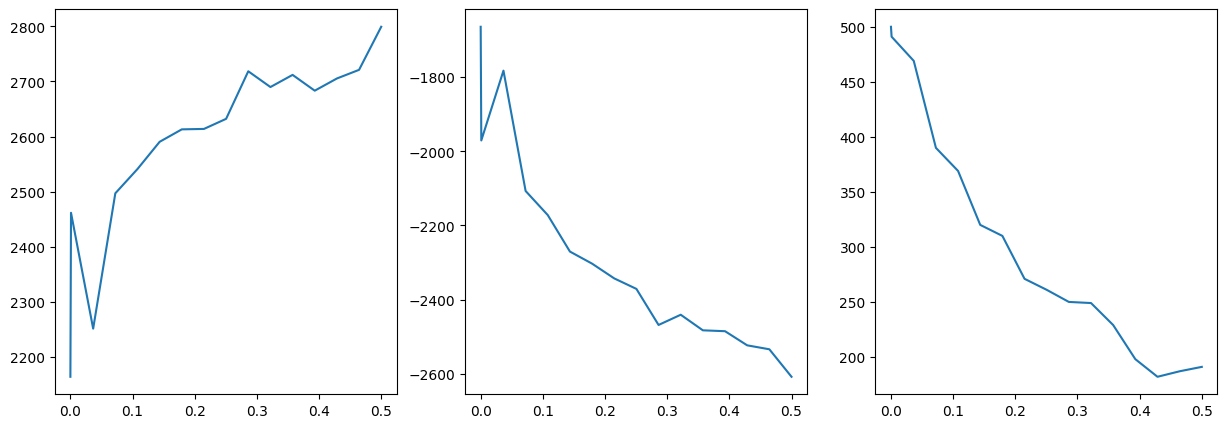

In [43]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].plot(alphas,nr_param_dict[100] + liks_dict[100])
ax[1].plot(alphas,-liks_dict[100])
ax[2].plot(alphas,nr_param_dict[100])

# Compare student t and Gaussian

In [46]:
tol = 1e-6
max_iter = 200
nu = 5
# test parameters
ns = [1000]
rs = [5, 10, 20, 30, 40, 50, 100]
ds = [10]
alphas = np.concatenate(([0], np.logspace(-5,-3, 70)))

rnd = np.random.RandomState(42)


        

# Storetrue data and coef
B_dict_true = dict()
A_dict_true = dict()
Ys_dict_cov = dict()
Ys_dict_meancov = dict()


X = rnd.normal(loc = 0, scale = 1, size = (np.max(ns),np.max(rs)))


# Generate coef matrix
for r in rs:
    for d in ds:
        B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
        B_true[np.abs(B_true)<0.7] = 0
        B_dict_true[str(r) + '_'+str(d)] = B_true
        A_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
        A_true = A_true*(rnd.uniform(size = (d,r) ) <0.6)
        A_dict_true[str(r) + '_'+str(d)] = A_true

# Generate observations

st_dist = student_t(df = 5, scale = 0.1)
st_dist.random_state = np.random.RandomState(5)
for r in rs:
    for d in ds:
        B_tmp = B_dict_true[str(r) + '_'+str(d)].copy()
        A_tmp = A_dict_true[str(r) + '_'+str(d)].copy()

        X_tmp = X[:,:r]
        gamma = rnd.normal(loc = 0, scale = 1, size = (np.max(ns)))
        epsilon = st_dist.rvs(size = (np.max(ns), d))

        Y_cov = gamma[:, np.newaxis]*np.dot(X_tmp, B_tmp.T) + epsilon
        Ys_dict_cov[str(r) + '_'+str(d)] = Y_cov.copy()


        Y_meancov = np.dot(X_tmp, A_tmp.T) + gamma[:, np.newaxis]*np.dot(X_tmp, B_tmp.T) + epsilon
        Ys_dict_meancov[str(r) + '_'+str(d)] = Y_meancov.copy()

In [52]:
# with open(f'./data_sim/shapley_t_secant_cole.pkl', 'rb') as handle:
#     shapley_t_secant = pickle.load(handle)

x = X[:1000,:20] #shapley_t_secant['X'][:1000,:5]
y = Ys_dict_cov[str(20) + '_'+str(10)][:1000] #shapley_t_secant['Ys_dict_cov'][str(5) + '_'+str(10)][:1000]
B_true = B_dict_true['20_10']
max_i, max_j = np.where(B_true == np.max(B_true))



In [47]:
cov_t = cr.CovReg( Y = y, alpha = 0, max_iter = 3000, tol = tol, method = 'direct')
cov_t.fit_hoff_b_only(X2 = x, verbose = False, C_init = 'cole', error = 't', nu = 5, sample='sample')
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_t.B[max_i, max_j])*cov_t.B - B_true)


42.76648507689055

In [48]:
cov_direct = cr.CovReg( Y = y, alpha = 0, max_iter = 3000, tol = tol, method= 'direct')
cov_direct.fit_hoff_b_only(X2 = x, verbose = False, C_init = 'cole', error = 'gaussian')
np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(cov_direct.B[max_i, max_j])*cov_direct.B - B_true)

45.421825729489846

In [34]:
# #with open(f'C:/Users/ragna/Documents/Code/DyGraph/CovRegressionPaper/data_sim/shapley_less.pkl', 'rb') as handle:
# with open(f'./data_sim/new_con_exp_shapley_t_secant_cole.pkl', 'rb') as handle:
#     shapley_t_secant = pickle.load(handle)
# print(shapley_t_secant.keys())


with open(f'./data_sim/new_con_exp_shapley_t_secant_nu5_scale0.1_cole.pkl', 'rb') as handle:
    shapley_t_secant = pickle.load(handle)
print(shapley_t_secant.keys())




#max_i, max_j = np.where(B_true == np.max(B_true))

dict_keys(['marg_liks_dict', 'liks_dict', 'l2_dict', 'psi_est', 'nr_param_dict', 'B_est', 'marg_liks_dict_t', 'liks_dict_t', 'l2_dict_t', 'psi_est_t', 'nr_param_dict_t', 'B_est_t', 'B_true', 'Ys_dict_cov', 'X'])


In [35]:
def plot_error_per_r(shapley_t_secant, a_idx):

    rs = [5, 10, 20, 30, 40, 50, 100]
    error_g = np.zeros(len(rs))
    error_t = np.zeros(len(rs))
    for r_cnt, r in enumerate(rs):
        B_est_g = shapley_t_secant['B_est'][r][1000][a_idx]
        B_est_t = shapley_t_secant['B_est_t'][r][1000][a_idx]
        B_true = shapley_t_secant['B_true'][str(r)+ '_10']
        
        max_i, max_j = np.where(B_true == np.max(B_true))
        error_g[r_cnt] = np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(B_est_g[max_i, max_j])*B_est_g - B_true)
        error_t[r_cnt] = np.linalg.norm(np.sign(B_true[max_i, max_j])*np.sign(B_est_t[max_i, max_j])*B_est_t - B_true)

    
    fig, ax = plt.subplots(1,1, figsize = (10,6))

    ax.plot(rs, np.log(error_g), label = 'Gaussian model')
    ax.plot(rs, np.log(error_t), label = 'Student t model')
    ax.legend()
    ax.set_xlabel('r')
    ax.set_ylabel('log error')



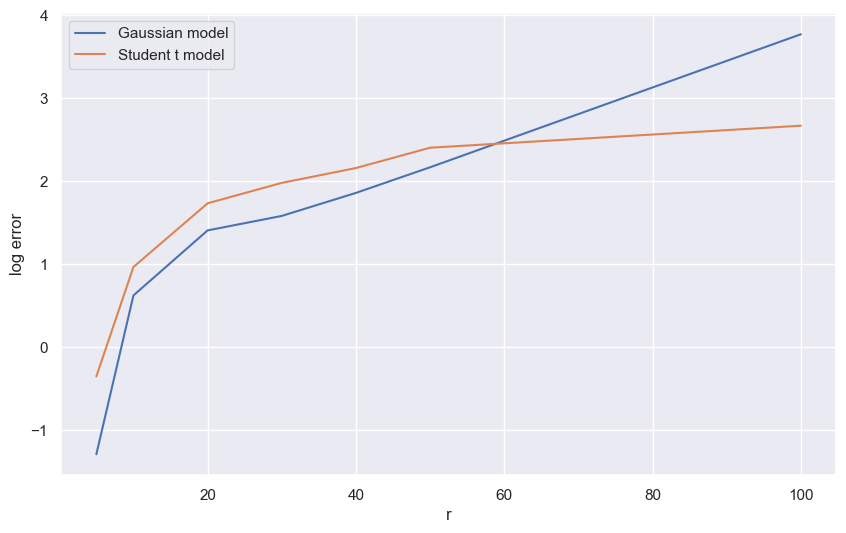

In [36]:
plot_error_per_r(shapley_t_secant, 0)

def plot

# Regularization on True B

## Only B

In [22]:
print(np.round(np.abs(B_dict_true[str(20) + '_'+str(10)][1,:]),2))
print(np.round(np.abs(B_dict_cov[str(20) + '_'+str(10)][3,36][1,:]),2))

[0.72 0.   0.   0.   0.34 1.96 1.66 0.   0.76 0.   0.   0.38 0.   1.09
 0.   0.   0.   0.68 0.   0.9 ]


IndexError: index 3 is out of bounds for axis 0 with size 3

NameError: name 'ns' is not defined

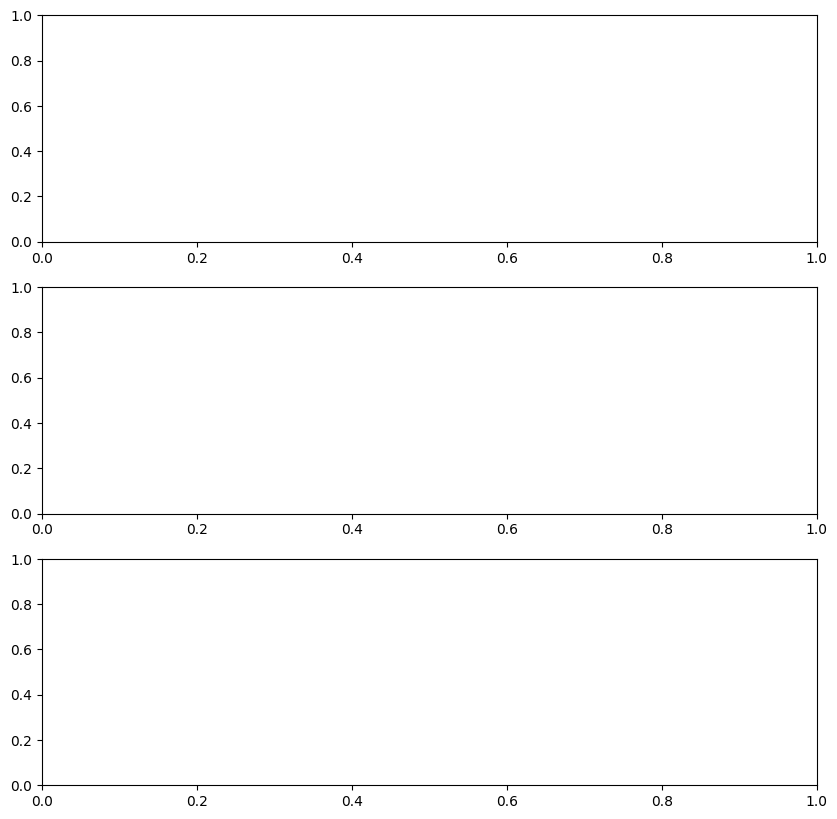

In [10]:
fig, ax = plt.subplots(3,1, figsize = (10,10))

cnt = 0
for r, d in [(20, 10), (50, 10), (100, 10)]:
    for k in range(len(ns)):

        #ax[cnt].plot(alphas, [np.sum(np.abs(np.abs(B_dict_true[str(r) + '_'+str(d)]) - np.abs(B_dict_cov[str(r) + '_'+str(d)][k,i])))/np.sum(np.abs(B_dict_true[str(r) + '_'+str(d)])) for i in range(B_dict_cov[str(r) + '_'+str(d)].shape[1])], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
        ax[cnt].plot(alphas, [np.linalg.norm(np.abs(np.abs(B_dict_true[str(r) + '_'+str(d)]) - np.abs(B_dict_cov[str(r) + '_'+str(d)][k,i]))) for i in range(B_dict_cov[str(r) + '_'+str(d)].shape[1]) ], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[cnt].legend()
    ax[cnt].set_ylabel("B vs B_true")
    ax[cnt].set_xlabel("Regularization")
    ax[cnt].set_title(f'r = {r}, d = {d}')
    ax[0].set_ylim((0,10))
    ax[1].set_ylim((0,20))
    ax[2].set_ylim((0,25))
    cnt+=1

## B and A

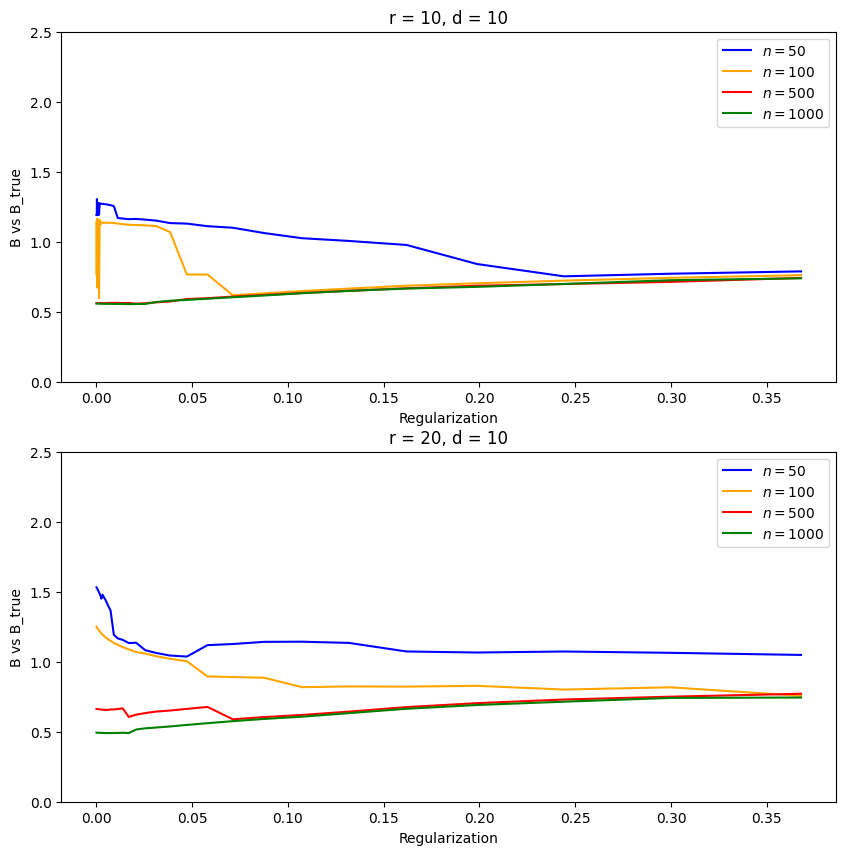

In [6]:
fig, ax = plt.subplots(2,1, figsize = (10,10))

cnt = 0
for r, d in [(10, 10), (20,10)]:
    for k in range(len(ns)):

        ax[cnt].plot(alphas, [np.sum(np.abs(np.abs(B_dict_true[str(r) + '_'+str(d)]) - np.abs(B_dict_meancov[str(r) + '_'+str(d)][k,i])))/np.sum(np.abs(B_dict_true[str(r) + '_'+str(d)])) for i in range(B_dict_meancov[str(r) + '_'+str(d)].shape[1])], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[cnt].legend()
    ax[cnt].set_ylabel("B vs B_true")
    ax[cnt].set_xlabel("Regularization")
    ax[cnt].set_title(f'r = {r}, d = {d}')
    ax[cnt].set_ylim((0,2.5))
    cnt+=1

# Regularization on AIC

In [27]:


B_dict_true[str(r) + '_'+str(d)].shape

(10, 100)

## only B

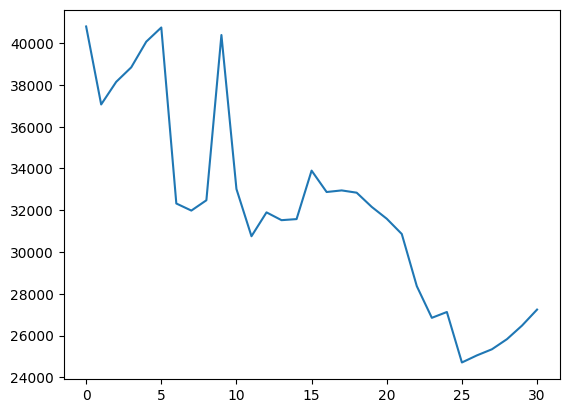

In [20]:
plt.plot(lik_cov_dict['100_10'][2])

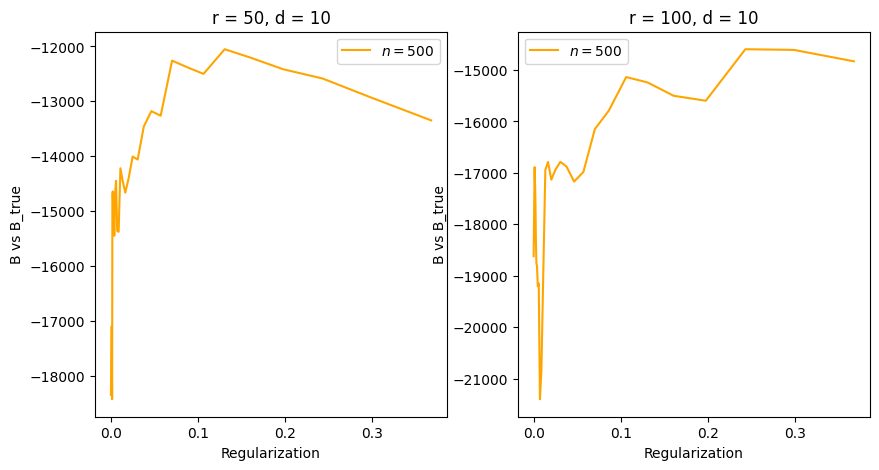

In [21]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
cnt = 0
for r, d in [ (50,10), (100,10)]: #(10, 10), (20,10),
    for k in [1]: #range(len(ns))

        ax[cnt].plot(alphas, nr_param_cov_dict[str(r) + '_'+str(d)][k]-lik_cov_dict[str(r) + '_'+str(d)][k] , label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[cnt].legend()
    ax[cnt].set_ylabel("B vs B_true")
    ax[cnt].set_xlabel("Regularization")
    ax[cnt].set_title(f'r = {r}, d = {d}')
    #ax[cnt].set_ylim((0,2.5))
    cnt+=1

In [10]:
def likelihood(B, X, Y, psi, A = None):
    from scipy.stats import multivariate_normal
    lik = 0.0
    for t in range(X.shape[0]):
        cov = np.dot(B, np.outer(X[t],X[t])).dot(B.T)+ psi
        if A is not None:
            mean = np.dot(A, X[i])
        else:
            mean = None
        
        lik+= multivariate_normal.logpdf(Y[t], cov = cov, mean = mean, allow_singular = True)

    return lik

In [24]:
B_dict_cov[str(r) + '_'+str(d)][0].shape
Xs_dict = shap_data['Xs_dict']
Y_cov = shap_data['Ys_dict_cov']

(31, 10, 100)

In [46]:
lik_vec = []
lik_vec_psi = []

nr_param_vec = []
nr_param_vec_psi = []

r = 100
d = 10
n_idx = 3
Psi_dict_cov = shap_data['Psi_dict_cov']
for a_idx  in range(len(alphas)):
    print(a_idx)
    B = B_dict_cov[str(r) + '_'+str(d)][n_idx][a_idx].copy()
    B_psi = B_dict_cov_psi[str(r) + '_'+str(d)][n_idx][a_idx].copy()
    psi = Psi_dict_cov[str(r) + '_'+str(d)][n_idx][a_idx].copy()
    psi_true = np.identity(d)
    X = Xs_dict[str(r)][n_idx].copy()
    Y = Y_cov[str(r) + '_'+str(d)][n_idx].copy()

    lik_vec_psi.append(likelihood(B_psi, X, Y, psi_true))
    lik_vec.append(likelihood(B, X, Y, psi))

    nr_param_vec_psi.append(np.sum(np.abs(B_psi)>1e-3))
    nr_param_vec.append(np.sum(np.abs(B)>1e-3))






0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [5]:
r = 100
d = 10
lik_vec_psi = np.zeros(len(alphas))
nr_param_vec_psi = np.zeros(len(alphas))
for a_idx, alpha in enumerate(alphas):
    Y_tmp = Y_cov[str(r) + '_'+str(d)][3].copy()
    X_tmp = Xs_dict[str(r)][3].copy()
    cov = cr.CovReg( Y = Y_tmp, alpha = alpha, max_iter = 1000, tol = 1e-3)
    cov.fit_hoff_b_only(X2 = X_tmp, psi = np.identity(d), verbose = True)

    lik_vec_psi[a_idx], nr_param_vec_psi[a_idx] = cov.marg_lik(X1 = None, X2 = X_tmp)

    #lik_vec_psi.append(likelihood(cov.B, X_tmp, Y_tmp, np.identity(d)))

  0%|          | 0/1000 [00:00<?, ?it/s]

Error 4.88E-4:   2%|▏         | 20/1000 [00:03<02:37,  6.21it/s]


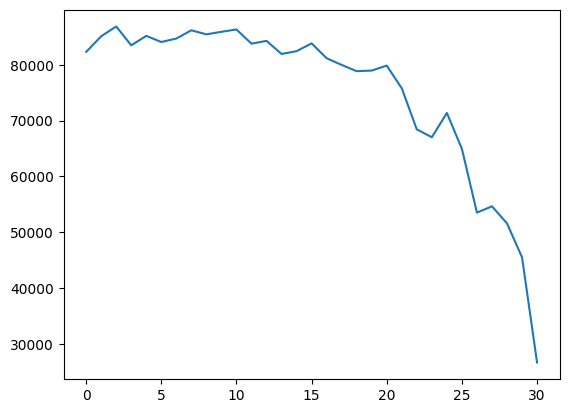

In [17]:
plt.plot(lik_vec_psi)

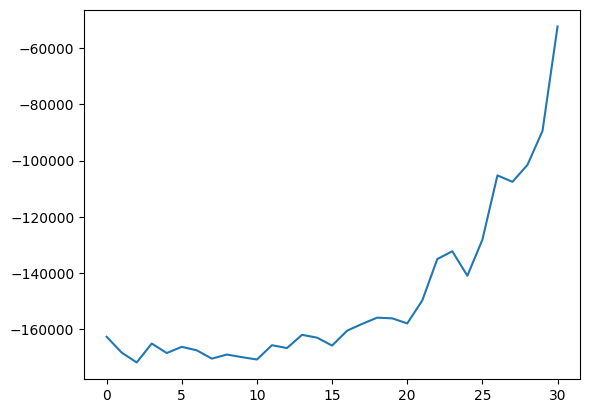

In [11]:
plt.plot(nr_param_vec_psi*2-2*lik_vec_psi)

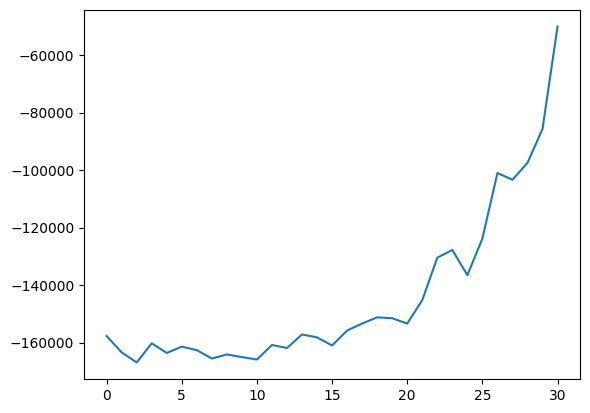

In [9]:
plt.plot(nr_param_vec_psi*np.log(1000)-2*lik_vec_psi)

In [10]:
r = 100
d = 10
lik_vec = np.zeros(len(alphas))
nr_param_vec = np.zeros(len(alphas))
for a_idx, alpha in enumerate(alphas):
    Y_tmp = Y_cov[str(r) + '_'+str(d)][3].copy()
    X_tmp = Xs_dict[str(r)][3].copy()
    cov = cr.CovReg( Y = Y_tmp, alpha = alpha, max_iter = 200, tol = 1e-3)
    cov.fit_hoff_b_only(X2 = X_tmp, verbose = True)

    lik_vec[a_idx], nr_param_vec[a_idx] = cov.marg_lik(X1 = None, X2 = X_tmp)

    #lik_vec_psi.append(likelihood(cov.B, X_tmp, Y_tmp, np.identity(d)))

  0%|          | 0/200 [00:00<?, ?it/s]

Error 1.00E+4: 100%|██████████| 200/200 [00:14<00:00, 13.59it/s]


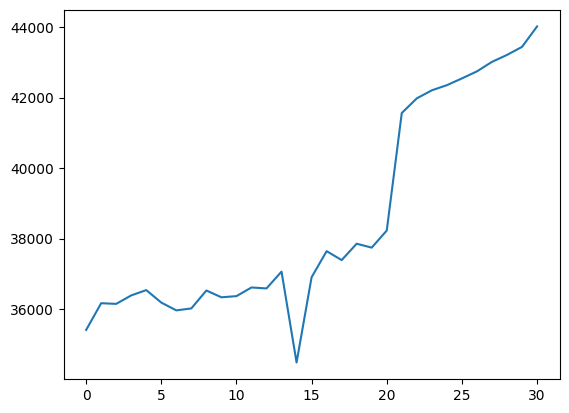

In [11]:
plt.plot(lik_vec)

In [13]:
nr_param_vec

array([1000., 1000., 1000., 1000., 1000.,  999., 1000., 1000., 1000.,
       1000., 1000., 1000.,  998.,  999.,  949.,  999.,  997.,  994.,
        993.,  995.,  986.,  769.,  656.,  576.,  527.,  485.,  458.,
        366.,  292.,  195.,   13.])

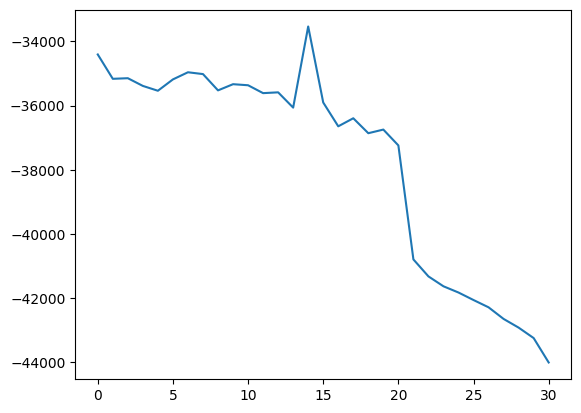

In [12]:
plt.plot(nr_param_vec-lik_vec)

In [57]:
np.round(cov.B[0,:],2)

array([ 0.03, -0.21,  0.16, -0.33, -0.11, -0.54,  0.2 , -0.54, -0.11,
       -0.25, -0.18,  0.24,  0.29, -0.11,  0.31,  0.21, -0.18, -0.21,
       -0.42,  0.15, -0.07,  0.24, -0.36, -0.05,  0.08, -0.27,  0.43,
       -0.02, -0.15,  0.09,  0.18, -0.01,  0.15,  0.05, -0.38, -0.01,
       -0.01,  0.24, -0.29,  0.  ,  0.03,  0.33, -0.83, -0.35, -0.37,
        0.02,  0.13,  0.24, -0.24, -0.02,  0.59,  0.95, -0.01, -0.15,
        0.07,  0.43, -0.06,  0.08,  0.  , -0.15, -0.41, -0.32,  0.11,
        0.06, -0.09,  0.25, -0.  ,  0.17,  0.48, -0.03, -0.21,  0.13,
        0.29, -0.01, -0.39, -0.14, -0.21,  0.42, -0.24, -0.28, -0.84,
       -0.06,  0.05,  0.2 , -0.07,  0.19,  0.28, -0.2 ,  0.11,  0.25,
       -0.11,  0.13,  0.25,  0.14,  0.28,  0.4 , -0.28, -0.07,  0.06,
        0.17])

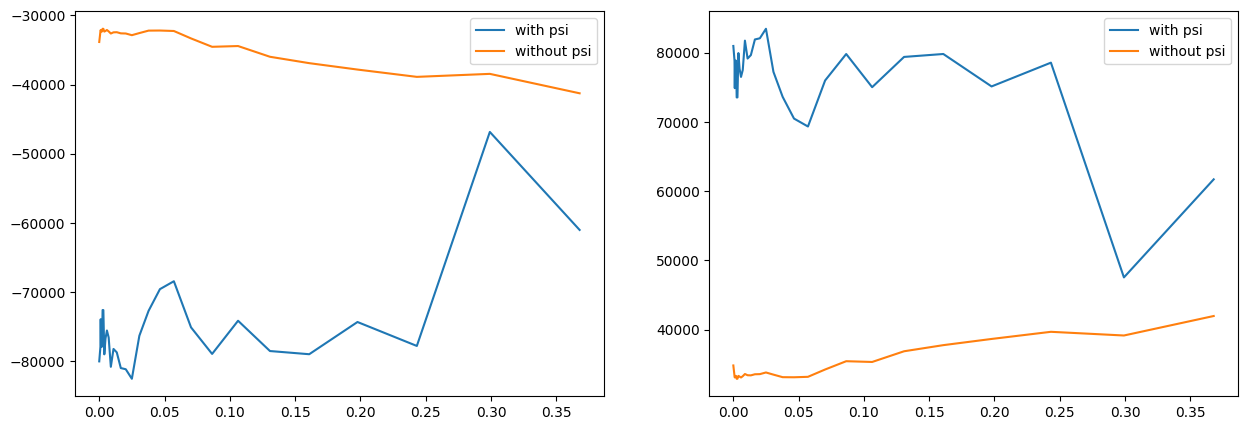

In [51]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(alphas, lik_vec_psi, label = 'with psi')
ax[0].plot(alphas, lik_vec, label = 'without psi')
ax[0].legend()

ax[1].plot(alphas, np.array(nr_param_vec_psi)-np.array(lik_vec_psi), label = 'with psi')
ax[1].plot(alphas, np.array(nr_param_vec) - np.array(lik_vec), label = 'without psi')
ax[1].legend()

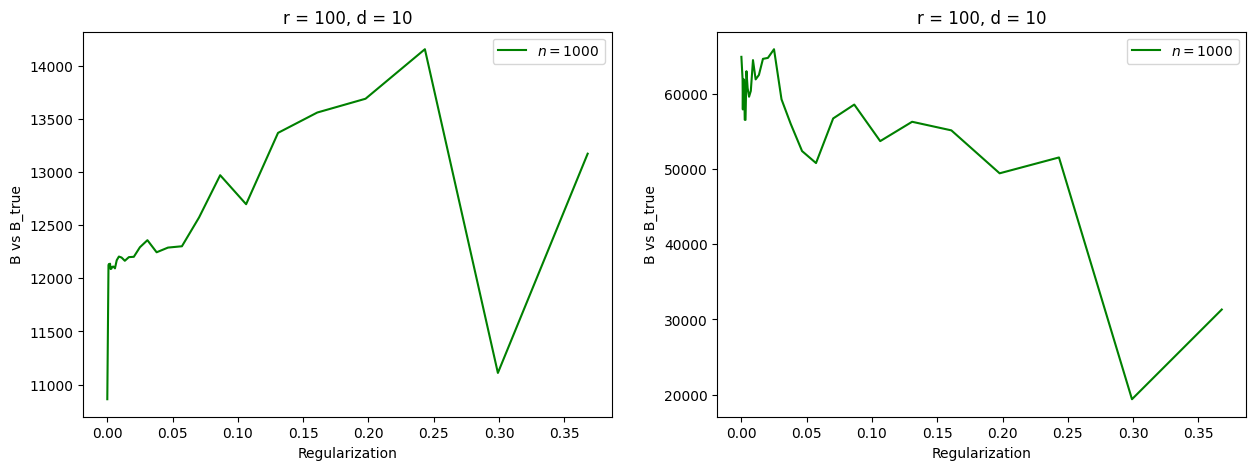

In [21]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

cnt = 0
for r, d in [(100,10)]:

    ax[0].plot(alphas,nr_param_cov_dict[str(r) + '_'+str(d)][3]+lik_cov_dict[str(r) + '_'+str(d)][3], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[0].legend()
    ax[0].set_ylabel("B vs B_true")
    ax[0].set_xlabel("Regularization")
    ax[0].set_title(f'r = {r}, d = {d}')


    ax[1].plot(alphas,nr_param_cov_psi_dict[str(r) + '_'+str(d)][3]+lik_cov_psi_dict[str(r) + '_'+str(d)][3], label = f'{r"$n = $"}{ns[k]}', color = colors[k])
    ax[1].legend()
    ax[1].set_ylabel("B vs B_true")
    ax[1].set_xlabel("Regularization")
    ax[1].set_title(f'r = {r}, d = {d}')
    #ax[1].set_ylim((4000, 8000))

# Temporal Shapley experiment

In [30]:
from sklearn.datasets import make_sparse_spd_matrix
rnd = np.random.RandomState(2)
r = 12
R = make_sparse_spd_matrix(dim=r, alpha = 0.5,random_state=42,norm_diag=True)
#print(R)

alpha_1 = 0.1*rnd.uniform(size = R.shape[0] )
#alpha_1[2] = 0
#alpha_1[3] = 0
alpha_0 = 1
beta_1 = 0.1
print(beta_1 + np.dot(alpha_1, R).dot(alpha_1))
assert beta_1 + np.dot(alpha_1, R).dot(alpha_1)<1

# Generate a path
T = 100
x = []
sigmas = np.zeros(T+1)
sigmas[0] = 1.12
x = np.zeros((T,r))
for i in range(T):
    x[i] = rnd.multivariate_normal(mean = np.zeros(R.shape[0]), cov = R*sigmas[i])
    sigmas[i+1] = alpha_0 + np.dot(alpha_1, np.outer(x[i],x[i])).dot(alpha_1) + beta_1*sigmas[i]


d = 12
gamma = rnd.normal(loc = 0, scale = 1, size = (T))
epsilon = rnd.normal(loc = 0, scale = 1, size = (T,d))
B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
B_true =B_true*(rnd.uniform(size = (d,r) ) <0.3)


#Y = gamma[:, np.newaxis]*np.dot(x, B_true.T) + epsilon


const = beta_1 + np.dot(alpha_1, R).dot(alpha_1)
uncond_cov = R*alpha_0/(1-const)

uncond_shap = calc_shapley_value(B_true,x, Sigma = uncond_cov)


cond_shap = np.zeros((T, int(d*(d+1)/2), r))
cond_cov = np.zeros((T,r,r))
for t in range(T):
    cond_cov[t] = R*sigmas[t]
    cond_shap[t] = calc_shapley_value(B_true, x, Sigma = cond_cov[t])

val_y = np.dot(B_true, uncond_cov).dot(B_true.T)


0.11419093260990426


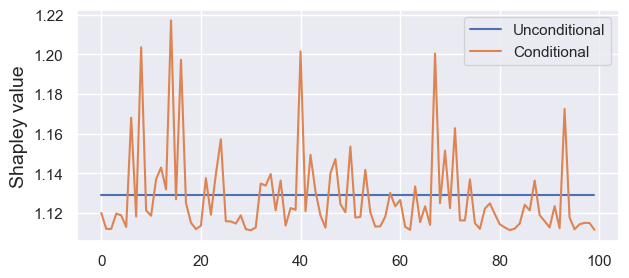

In [44]:
node_idx = 1
fig, ax = plt.subplots(1,1, figsize = (7,3))

ax.plot(range(T), [uncond_cov[node_idx, node_idx]]*T, label = 'Unconditional')
# ax.plot(range(T), [uncond_cov[0, 0]]*T)
ax.plot(range(T), cond_cov[:,node_idx,node_idx], label = 'Conditional')
ax.set_ylabel("Shapley value", fontdict={'fontsize':14})
ax.legend()


Single element Shapley for one node

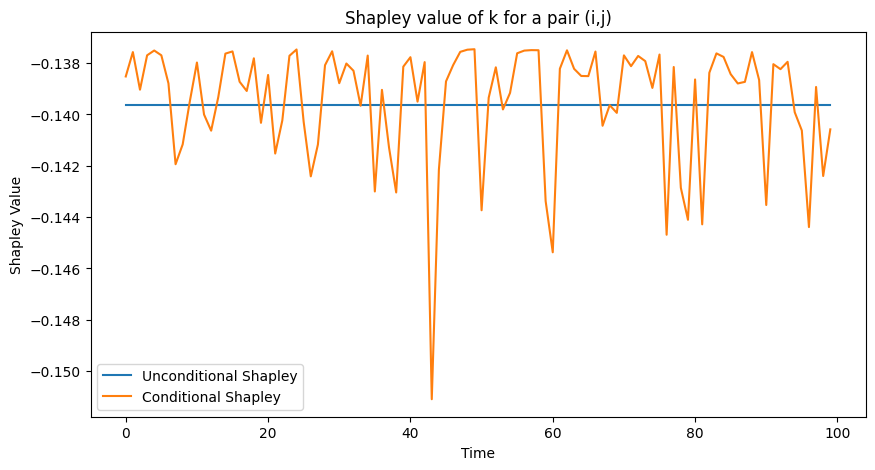

In [19]:
ij = 3
node_idx = 1
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(range(T), [uncond_shap[ij, node_idx]]*T, label = "Unconditional Shapley")
ax.plot(range(T), cond_shap[:, ij, node_idx], label = "Conditional Shapley")
ax.set_ylabel("Shapley Value")
ax.set_xlabel("Time")
ax.set_title("Shapley value of k for a pair (i,j)")
ax.legend()

Aggregated Shapley for one node

In [1]:
ij = 3
node_idx = 1
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(range(T), [np.sum(uncond_shap[:, node_idx], 0)]*T, label = "Unconditional Shapley")
ax.plot(range(T), np.sum(cond_shap[:, :, node_idx], 1), label = "Conditional Shapley")
ax.set_ylabel("Shapley Value")
ax.set_xlabel("Time")
ax.set_title("Aggregated Shapley value of k")
ax.legend()

NameError: name 'plt' is not defined

Do the same but for GGP

3.320116922736544
[[ 0.57911865 -0.26683564  0.86157456  0.44865749  1.03810521  0.95400861]
 [ 0.47819302 -0.17859233  0.78967343  0.37724512  1.08691968  0.66853651]
 [ 0.43805654 -0.13236456  0.72426918  0.32612877  1.11627118  0.54408166]
 [ 0.43006902 -0.12177805  0.61492305  0.34734373  1.10681598  0.31074908]
 [ 0.41232757 -0.16114719  0.49255184  0.33459281  1.10713083  0.18317802]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[-0.66809045  0.99204235 -0.17495976 -0.75574516  0.53650984 -0.89846798]
 [ 0.02818116 -0.009119    1.08589557  0.47469823 -0.02502696  0.8177663 ]]
[ 0.1252245  -0.42940554]


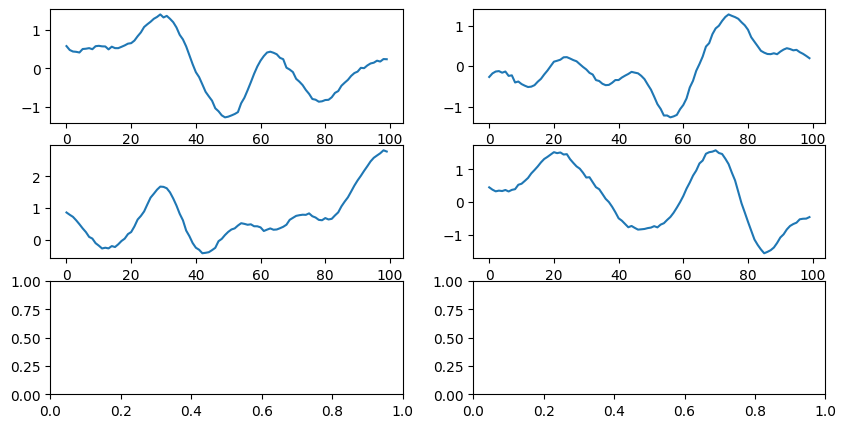

In [18]:
rnd = np.random.RandomState(42)


n = 100
d = 6
r = 6
X = rnd.normal(loc = 0, scale = 1, size = (n,r))


G = nx.fast_gnp_random_graph(r, 3/r,    seed = 1)

v, u = np.linalg.eigh(nx.laplacian_matrix(G).todense())

H = np.array(np.dot(u, np.diag(np.exp(-0.1*v))).dot(u.T))
print(np.linalg.cond(np.dot(H,H)))


#T  = np.random.normal(loc = 0, scale = 1, size = (n,r)) 
T = np.linspace(1,10,n).reshape(-1,1)
K = rbf_kernel(T,T, gamma = 1) + 0.001*np.identity(n)
# print(K[:,0])

omega = 1
matrix_normal.random_state = rnd
F_true = matrix_normal.rvs(np.zeros((n,r)), rowcov = K, colcov = np.dot(H,H)*(1/omega) )
H_sq  = np.dot(H,H)

scale = 1
psi = scale*np.identity(d)
psi_inv = np.linalg.inv(psi)

gamma = rnd.normal(loc = 0, scale = 1, size = (n))
epsilon= rnd.normal(loc = 0, scale = scale, size = (n,d))
#B_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
#A_true = np.random.normal(loc = 0, scale = 0, size = (d,r))
P = rnd.binomial(1,0.5,size = (d,r) )
#A_true = rnd.uniform(0.5,1,size = (d,r))*P + np.random.uniform(-1,-0.5,size = (d,r))*(1-P)
B_true = rnd.uniform(-1,1,size = (d,r))#*0
B_true[np.abs(B_true)<0.5] = 0#*(np.random.uniform(size = (d,r) ) <0.5)
A_true = np.zeros((d,r))# A_true*(rnd.uniform(size = (d,r) ) <0.5)

Y = np.dot(F_true, A_true.T) +  gamma[:, np.newaxis]*np.dot(F_true, B_true.T) + epsilon

fig, ax = plt.subplots(3,2, figsize = (10,5))
ax[0,0].plot(F_true[:,0])
ax[0,1].plot(F_true[:,1])
ax[1,0].plot(F_true[:,2])
ax[1,1].plot(F_true[:,3])
#ax[2,0].plot(F_true[:,4])
#ax[2,1].plot(F_true[:,5])
#ax.plot(multivariate_normal.rvs(cov = rbf_kernel(np.linspace(1,10,100).reshape(-1,1),np.linspace(1,10,100).reshape(-1,1), gamma = 0.1)))

print(F_true[:5,:])
print(A_true[:2,:2])
print(B_true[:2,:2])
print(epsilon[:2])
print(gamma[:2])

In [44]:
B_true.shape

(6, 6)

In [50]:
np.array([K[t,s] for s in range(t)]).reshape((t,1))

array([[6.63967720e-36],
       [3.38237264e-35],
       [1.69479635e-34],
       [8.35285925e-34],
       [4.04924810e-33],
       [1.93079066e-32],
       [9.05560708e-32],
       [4.17754879e-31],
       [1.89560161e-30],
       [8.46046409e-30],
       [3.71417945e-29],
       [1.60381089e-28],
       [6.81184900e-28],
       [2.84576114e-27],
       [1.16937406e-26],
       [4.72639536e-26],
       [1.87900621e-25],
       [7.34764160e-25],
       [2.82611149e-24],
       [1.06918337e-23],
       [3.97865866e-23],
       [1.45627282e-22],
       [5.24288566e-22],
       [1.85660539e-21],
       [6.46681456e-21],
       [2.21555628e-20],
       [7.46615056e-20],
       [2.47475539e-19],
       [8.06843667e-19],
       [2.58742690e-18],
       [8.16146948e-18],
       [2.53215457e-17],
       [7.72740443e-17],
       [2.31952283e-16],
       [6.84833883e-16],
       [1.98881051e-15],
       [5.68097858e-15],
       [1.59615284e-14],
       [4.41110483e-14],
       [1.19906261e-13],


In [59]:
uncond_cov_gp = H_sq

uncond_shap_gp = calc_shapley_value(B_true,x, Sigma = uncond_cov_gp)


cond_shap_gp = np.zeros((n, int(d*(d+1)/2), r))
cond_cov_gp = np.zeros((n,r,r))
for t in range(1,n):
    k = np.array([K[t,s] for s in range(t)]).reshape((t,1))

    D = np.kron(H_sq,k)
    C = np.linalg.inv(np.kron(H_sq, K[:t, :t]))
    cov = K[t,t]*H_sq - np.dot(D.T, C).dot(D)
    mean = np.dot(np.kron(H_sq,k).T, F_true[:t,].flatten(order = 'F'))
    cond_cov_gp[t] = cov + np.outer(mean, mean)
    cond_shap_gp[t] = calc_shapley_value(B_true, None, Sigma = cond_cov_gp[t])





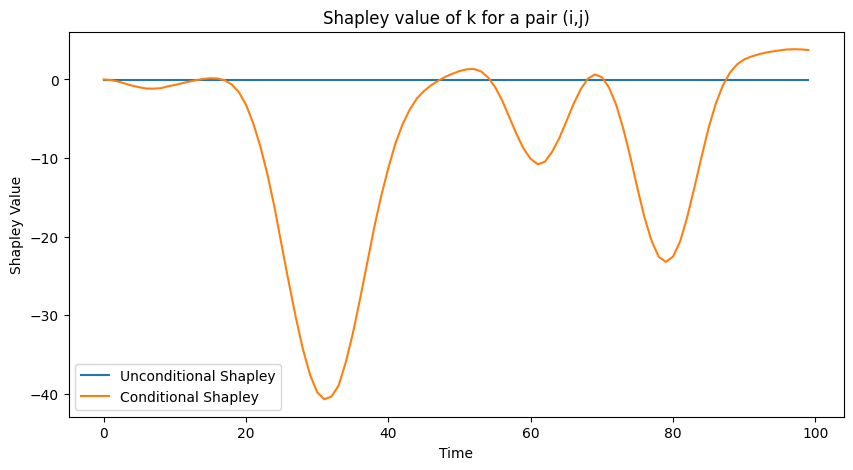

In [61]:
ij = 3
node_idx = 1
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(range(n), [uncond_shap_gp[ij, node_idx]]*n, label = "Unconditional Shapley")
ax.plot(range(n), cond_shap_gp[:, ij, node_idx], label = "Conditional Shapley")
ax.set_ylabel("Shapley Value")
ax.set_xlabel("Time")
ax.set_title("Shapley value of k for a pair (i,j)")
ax.legend()

# GP shapley find r

In [3]:
import gpflow
import tensorflow as tf

def calc_shapley_value(B,X=None, Sigma = None):
    if Sigma is None:
        Sigma = np.cov(X.T)
    
    r = Sigma.shape[0]
    val_y = np.dot(B, Sigma).dot(B.T)

    d = val_y.shape[0]
    shapleys = np.zeros((int(d*(d+1)/2), r))
    index = np.arange(r)


    cnt=0
    shap_matrix = np.zeros((r,d,d))
    for i in range(d):
        for j in range(i,d):
            for k in range(r):
                t1 = B[i,k]*B[j,k]*Sigma[k,k]
                t2 = 0.5*np.sum(B[i,index != k]*B[j,k]*Sigma[k,index != k])
                t3 = 0.5*np.sum(B[j,index != k]*B[i,k]*Sigma[k,index != k])
                shapleys[cnt,k] = t1+t2+t3
                shap_matrix[k,i,j] = t1+t2+t3
            cnt+=1

    for k in range(r):
        shap_matrix[k] = shap_matrix[k]+shap_matrix[k].T -np.diag(shap_matrix[k])

    return shapleys, shap_matrix



rnd = np.random.RandomState(42)
n = 200
d = 10
r = 4
T = np.linspace(1,10,n).reshape(-1,1)

kernel_true = gpflow.kernels.RBF(variance=1, lengthscales=1) + gpflow.kernels.White(variance=0.1)

K = kernel_true.K(T)#rbf_kernel(T,T, gamma = 0.1) + 0.01*np.identity(n)# linear_kernel(T,T)+ 0.001
K_inv = np.linalg.inv(K)
F_true = np.zeros((n, r))
for i in range(r):
    F_true[:,i] = rnd.multivariate_normal(mean = np.zeros(n), cov = K, size = 1)


H_test = np.identity(r)

scale = 0.1
psi = scale*np.identity(d)
psi_inv = np.linalg.inv(psi)
epsilon= rnd.normal(loc = 0, scale = scale, size = (n,d))
B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
Y_gp_true = np.dot(F_true, np.dot(H_test, B_true.T)) + epsilon

In [4]:
with open('shap_gp_experiment.pkl', 'rb') as handle:
    B_est_gps = pickle.load(handle)

In [11]:
B_est_gps.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
shapleys = dict()

for try_r in B_est_gps.keys():
    shapleys[try_r] = []
    B_tmp = B_est_gps[try_r]

    
    shap, shap_matrix = calc_shapley_value(B_tmp,X=None, Sigma = np.array(K[0,0])*np.identity(B_tmp.shape[1]))

    for r_idx in range(try_r):
        shapleys[try_r].append(np.trace(shap_matrix[r_idx]))



In [31]:
np.trace(np.dot(B_est_gps[1], np.array(K[0,0])*np.identity(B_est_gps[1].shape[1])).dot(B_est_gps[1].T))

149.26654973569168

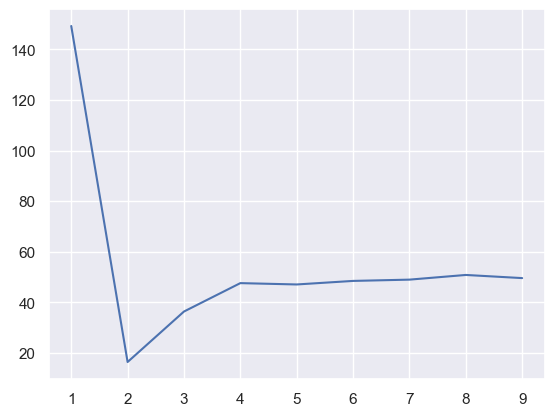

In [33]:
plt.plot([try_r for try_r in B_est_gps.keys()], [np.sum(shapleys[try_r]) for try_r in B_est_gps.keys()])